# I. Quantum Simulation of the XXX Heisenberg Spin Model with IBMQ Jakarta

__IBM Quantum - The Open Science Prize 2021__


Urbano L. França

__Contents__

I. [Quantum Simulation of the XXX Heisenberg Spin Model with Jakarta](#I.-Quantum-Simulation-of-the-XXX-Heisenberg-Spin-Model-with-IBMQ-Jakarta)

II. [The XXX Heisenberg Spin Model](#II.-The-XXX-Heisenberg-Spin-Model)

III. [Qiskit](#III.-Qiskit)

IV. [Qiskit Native Gates](#IV.-Qiskit-Native-Gates)

V. [Pulse Efficient Gates with Template Optimization](#V.-Pulse-Efficient-Gates-with-Template-Optimization)

VI. [Jakarta Experiments](#VI.-Jakarta-Experiments)

VII. [Conclusions and Future Directions](#VII.-Conclusions-and-Future-Directions)

VIII. [Appendix (_added post-submission_): Comparison with exact solution](#Appendix-(_added-post-submission_):-Comparison-with-exact-solution)


VIII. [References](#VIII.-References)

---


## I.1 Introduction and Objective of The Open Science Prize

From [The Open Science 2021 description](https://github.com/qiskit-community/open-science-prize-2021):


> One of the leading uses for quantum computers will be to simulate quantum systems such as molecules or engineered materials. Actually executing a quantum simulation on a current quantum computer, however, can be difficult and error prone. Your objective for this Open Science Prize is to significantly improve the state-of-the-art for quantum simulation.
>
> The quantum system you will simulate is a quantum spin-1/2 model, where each qubit represents a quantum [spin-1/2](https://en.wikipedia.org/wiki/Spin-1/2) particle in a 1D chain. Quantum spin models have some amazing properties and uses. Computationally speaking, [certain optimization problems can be mapped](https://arxiv.org/pdf/1712.05771.pdf) to spin models and hence minimized on a quantum computer. Physically speaking, spin models show a variety of quantum behavior such as large entangled states, quantum phases of matter, quantum many-body affects, and many other open questions in physics research.
>
> There are many different spin models, but we will focus on the [$XXX$ Heisenberg spin model](https://en.wikipedia.org/wiki/Quantum_Heisenberg_model#XXX_model). Though it is not as well known as the [transverse-field Ising model](https://en.wikipedia.org/wiki/Transverse-field_Ising_model), the $XXX$ Heisenberg model is of practical and theoretical interest. It can also be difficult to simulate, which is where you come in.
>
>[...]
>
>You are to time evolve the state $|110\rangle$ to time $t=\pi$ under the $XXX$ Heisenberg model Hamiltonian $H_{\text{heis3}}$ as defined in Section 1. This will be done on the ibmq_jakarta quantum computer. From left to right, the qubits in $|110\rangle$ correspond to ibmq_jakarta's qubits 5, 3, and 1. The evolution must be done using Trotterization with at least 4 steps ($n\geq4$). You will be judged on the clarity, originiality, and creativity of your solution, as well as the fidelity of the evolved state at time $t=\pi$ using [state tomography](https://qiskit.org/documentation/tutorials/noise/8_tomography.html). State tomography is a way of determining the exact quantum state--even phase information--at the end of a quantum circuit by running the circuit multiple times and measuring in different bases. The closer your final quantum state to the expected state, the higher the fidelity. Ibmq_jakarta's qubits 0, 2, 4, and 6 will not be evaluated by the state tomography calculation, so you may use them as you wish. You do not need to follow the same decomposition given in the example above, but your solution must be a Trotterization of $U_{\text{heis3}}(t)$ with at least 4 steps ($n\geq4$). You may find it useful to implement techniques that reduce errors and improve qubit coherence.


## I.2 Approach

In this notebook, we describe and calculate different approaches and methodologies to evolve the state $|110\rangle$ to time $t=\pi$ for the XXX Heisenberg model Hamiltonian. Some of our approaches use some native gates, while others use pulse-efficient gates, with and without measurement error mitigation, to increase the state fidelity of simulations. The simulations are run using the noisy simulator `FakeJakarta()` and the final experiments are run in IBMQ's Jakarta device using the parameters of the simulations with the highest fidelities. We show that __pulse-efficient simulations using the template optimization methodology of [Earnest et al. 2021](https://arxiv.org/abs/2105.01063) can reach state fidelities of $\approx$ 0.80-0.85 in the Jakarta device for 10$ \lesssim n\lesssim $ 13 Trotter steps__. Our final run uses $n=11$. 

This notebook is organized as follows: in Section [II](II.-The-XXX-Heisenberg-Spin-Model), we describe the XXX Heisenberg spin model and the decomposition of the Hamiltonian operator into quantum gates using the Suzuki-Trotterization decomposition. This discussion closely follows the [original notebooks](https://github.com/qiskit-community/open-science-prize-2021) provided by the organizers of the Open Science Prize 2021. Sec. [III](#III.-Qiskit) imports the packages and backends used in the notebook and contains some functions that will be useful in the simulations and device executions. 

In the subsequent two sections, we describe in detail the methodologies used in this notebook to simulate the Heisenberg model and to compare their results. These tests are run on a Jakarta simulator, `FakeJakarta`, and are executed using between 4 and 13 Trotter steps to evaluate their performance with increasing Trotterization. In Sec. [IV](#IV.-Standard-Gates), we use the standard implementation of gates in Qiskit to run four different sets of experiments that will provide the baseline to compare the pulse-efficient solutions. We perform a noiseless test, a non-optimized quantum circuit execution, an optimized quantum circuit execution, and an optimized quantum circuit execution followed by measurement error mitigation using Qiskit's implementation of backend measurement calibration. In Sec. [V](#V.-Pulse-Efficient-Gates-with-Template-Optimization), we discuss pulse-efficient template optimization and implement this approach to generate pulse-efficient transpilations of the $XX(\theta)$, $YY(\theta)$, and $ZZ(\theta)$ gates. After comparing these gates with their standard CNOT-implemented counterparts, we demonstrate their performance with and without post-processing of the results using measurement error mitigation. Finally, based on the results of these experiments, we execute the circuits with higher performance on `ibmq_jakarta` and report their final results on the actual device in Sec. [VI](#VI.-Jakarta-Experiments). 

_Added post-submission_: In the appendix, we show the $|110\rangle$ state evolution under the Hamiltonian for the different metodologies.

## I.3 Running this notebook

This notebook can be run in two ways: either (a) executing all `FakeJakarta` simulations to compare methodologies, which takes approximately 1h30-2h because of the relatively large number of simulations, or (b) executing only with the final experiments on the actual Jakarta device. 

__To execute only the experiments on Jakarta, set the flag below to `run_simulations = False`__ before running the entire notebook. This will skip all simulations but run the Jakarta experiments in Section VI. 

In [1]:
run_simulations = True

# II. The XXX Heisenberg Spin Model 
[[Go Back to Table of Contents](#I.-Quantum-Simulation-of-the-XXX-Heisenberg-Spin-Model-with-IBMQ-Jakarta)]

In this section, we brief summarize the description of the XXX Heisenberg spin model deliineated in the [original notebooks](https://github.com/qiskit-community/open-science-prize-2021) for the Open Science Prize 2021.

The Heisenberg model is described by the Hamiltonian operator,

$$
H_{\text{Heis}} = \sum_{\langle ij \rangle}^{N} J \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right),
$$

where $N$ is the total number of spin 1/2 particles in the model, $J$ is the interaction strength, $\langle ij \rangle$ denotes a sum running over the nearest neighbors, and $\sigma_x$, $\sigma_y$, and $\sigma_z$ are [Pauli operators](https://en.wikipedia.org/wiki/Pauli_matrices). In the particular case of this challenge, we will work with $N=3$ and  $J=1$, corresponding to the Hamiltonian,

$$
H_{\text{Heis3}} = 
\sum_{\langle ij \rangle}^{3} \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right) .
$$

Since this Hamiltonian is time independent, we can write the solution to the [Schrödinger equation](https://en.wikipedia.org/wiki/Schrödinger_equation) as 

$$
|\psi(t)\rangle = e^{-it H_\text{Heis3}}|\psi(t=0)\rangle  = U_{\text{Heis3}}(t)|\psi(t=0)\rangle , 
$$

where we use natural units ($\hbar = 1$) and the unitary operator is given by

$$
U_{\text{Heis3}}(t) 
= \exp\left[-it \sum_{\langle ij \rangle}^{3} \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right) \right] .
$$

Using the standard representation where the sum starts with the index $0$ instead of $1$, this Hamiltonian can be explicitly written as

$$
\begin{align}
U_{\text{Heis3}}(t) & = \exp\left[-it H_\text{Heis3}\right] \\
& =  \exp\left[-it \left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_z^{(0)}\sigma_z^{(1)} + \sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(1)}\sigma_z^{(2)}\right) \right] \\
&  = \exp\left[-i t \left(H^{(0,1)}_{\text{Heis2}} + H^{(1,2)}_{\text{Heis2}} \right)\right] , 
\end{align}
$$

where the local Hamiltonians $H^{(i,j)}_{\text{Heis2}} = \sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)} $ now act on a Hilbert space of dimension 2. We can use the Suzuki-Trotter decomposition to evolve the system locally over $n$ small, discrete time steps and approximate the operator sum by a product of exponentials,  

$$
\begin{align}
U_{\text{Heis3}}(t) & \approx \left[
\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{Heis2}}\right) 
\exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{Heis2}}\right)
\right]^n 
+ O\left( \dfrac{t^2}{n}\right) .
\end{align}
$$

The higher-order term is present because the Paulis do not commute [[Lloyd 1996](https://www.science.org/doi/10.1126/science.273.5278.1073), [Heras et al. 2014](https://arxiv.org/abs/1311.7626), [Tacchino et al. 2019](https://arxiv.org/abs/1907.03505)], but can be made small for sufficiently large $n$. For this reason, in what follows, we will use only the first-order term on $t$ in this equation. 

In principle, the approximation becomes more accurate as $n$ increases. In practice, however, adding extra steps to the Trotter approximation will also increase the circuit size and time of execution, potentially leading to the accumulation of gate errors and making decoherence more likely.  For this reason, when estimating the fidelities, we expect to observe a trade-off between the validity of approximation provided the Trotter decomposition for low $n$ and circuit size for high $n$. 
 
The equation above can be explicitly written as

$$
\begin{align}
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_z^{(0)}\sigma_z^{(1)}\right)\right) \exp\left(\dfrac{-it}{n}\left(\sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(1)}\sigma_z^{(2)}\right)\right)\right]^{n} \\
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\sigma_x^{(0)}\sigma_x^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(0)}\sigma_y^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_z^{(0)}\sigma_z^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_x^{(1)}\sigma_x^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(1)}\sigma_y^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_z^{(1)}\sigma_z^{(2)}\right)\right]^{n} \ ,
\end{align}
$$

where in the last step the Hamiltonians were once again decomposed because within each 2 spin subsystem the Pauli operator pairs $\sigma_x^{(i)}\sigma_x^{(j)}$, $\sigma_y^{(i)}\sigma_y^{(j)}$, and $\sigma_z^{(i)}\sigma_z^{(j)}$ commute.

Finally, we can use a more common notation to rename the products inside the unitary with $XX(2t) = \exp\left(-it \sigma_x\sigma_x\right)$, $YY(2t) = \exp\left(-it \sigma_y\sigma_y\right)$, and $ZZ(2t) = \exp\left(-it \sigma_z\sigma_z\right)$, allowing us to write $U_{\text{Heis3}}(t)$ as

$$
U_{\text{Heis3}}(t) \approx \left[XX\left(\frac{2t}{n}\right)^{(0,1)} YY\left(\frac{2t}{n}\right)^{(0,1)} ZZ\left(\frac{2t}{n}\right)^{(0,1)} XX\left(\frac{2t}{n}\right)^{(1,2)} YY\left(\frac{2t}{n}\right)^{(1,2)} ZZ\left(\frac{2t}{n}\right)^{(1,2)} \right]^{n} .
$$

This is the final form ot the Trotterized $U_{\text{Heis3}}(t)$ we will implement in the following sections.

# III. Qiskit
[[Go Back to Table of Contents](#I.-Quantum-Simulation-of-the-XXX-Heisenberg-Spin-Model-with-IBMQ-Jakarta)]

## III.1 Libraries and Backends

First, let's import some of the libraries used in this notebook.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import qiskit.quantum_info as qi
#plt.rcParams.update({'font.size': 16})

# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, execute, schedule, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import array_to_latex

# Import qubit states Zero (|0>) and One (|1>) and Pauli operators X, Y, Z, and I
from qiskit.opflow import Zero, One, I, X, Y, Z

from qiskit.quantum_info import Statevector
from qiskit.quantum_info import Operator
from qiskit.tools.monitor import job_monitor

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
from qiskit.test.mock import FakeJakarta

# Measurement calibrations
from qiskit import Aer
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.compiler import assemble

# Noise model
from qiskit.providers.aer.noise import NoiseModel

## Import Pulse modules
# The PassManager helps decide how a circuit should be optimized
# (https://qiskit.org/documentation/tutorials/circuits_advanced/04_transpiler_passes_and_passmanager.html)
from qiskit.transpiler import PassManager

# This function will pull pulse-level calibration values to 
# build RZX gates and tell the PassManager to leave RZX gates alone
from qiskit.transpiler.passes import RZXCalibrationBuilderNoEcho

from qiskit.circuit.library.standard_gates.equivalence_library import (
    StandardEquivalenceLibrary as std_eqlib,
)
from qiskit.transpiler.passes import (
    TemplateOptimization,
    Collect2qBlocks,
    ConsolidateBlocks,
    UnrollCustomDefinitions,
    BasisTranslator,
    Optimize1qGatesDecomposition,
)

#from qiskit.transpiler.passes.calibration.builders import RZXCalibrationBuilderNoEcho

from qiskit.transpiler.passes.optimization.echo_rzx_weyl_decomposition import (
    EchoRZXWeylDecomposition,
)


# Supress warnings
import warnings
warnings.filterwarnings('ignore')

<ipython-input-2-dc07fba1b99a>:20: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


We will also import the backends used in the different sections. While the final runs (Sec. [VI](#VI.-Jakarta-Runs)) are performed on the Jakarta backend, most tests and simulations are run on `FakeJakarta()`, chosen because of its capability to run Qiskit Pulse jobs. The baseline noiseless simulation is executed on the `QasmSimulator()` and a measurement calibration simulations used for measurement error mitigation are run on the noisy Jakarta backend `sim_noisy_jakarta`.

In [3]:
## load IBMQ account
# IBMQ.save_account(TOKEN)
provider = IBMQ.load_account()

# Noiseless simulated backend
sim = QasmSimulator()

Below we load `ibmq_jakarta` and test for its Pulse support.

In [4]:
hub = 'ibm-q-community' 
group = 'ibmquantumawards'
project = 'open-science-22'
provider = IBMQ.get_provider(hub=hub, group=group, project=project)
backend = provider.get_backend('ibmq_jakarta')
jakarta_backend = provider.get_backend('ibmq_jakarta')

try:
    # Check if backend supports Pulse
    backend_config = jakarta_backend.configuration()
    assert backend_config.open_pulse
    print("Backend supports Pulse")
except:
     print("Backend does not support Pulse")

Backend supports Pulse


Similarly for `sim_noisy_jakarta`:

In [5]:
#Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

try:
    # Check if backend supports Pulse
    backend_config = sim_noisy_jakarta.configuration()
    assert backend_config.open_pulse
    print("Backend supports Pulse")
except:
     print("Backend does not support Pulse")

Backend does not support Pulse


Because `sim_noisy_jakarta` does not support Pulse, we will use `FakeJakarta` for all noisy simulations in this notebook. 

In [6]:
fake_jakarta_backend = FakeJakarta()

try:
    # Check if backend supports Pulse
    backend_config = fake_jakarta_backend.configuration()
    assert backend_config.open_pulse
    print("Backend supports Pulse")
except:
     print("Backend does not support Pulse")


Backend supports Pulse


## III.2 Auxiliary functions and definitions

To simplify the notebook, we can define a few auxiliary functions which will be used repeatedly in the experiments below. These functions implement the state tomography used in the [original notebooks](https://github.com/qiskit-community/open-science-prize-2021), execute Trotter jobs for a predefined number of steps using the different methodologies of each section, plot the comparisons between different Trotter runs and experiments, and eliminate idle wires in certain circuits.

But first, all simulations will be run using a different number of Trotter steps to evaluate their state fidelities. In the cell below, we select the minimum and maximum number of Trotter steps we aim to investigate in our experiments. As mentioned in the [Introduction](#I.1-Introduction), we calculate 10 different number of steps $n$ for each methodology, from $n = 4$ and $n=13$, but this can be changed here if we want to try a different number of steps.

In [7]:
n_min_trotter = 4
n_max_trotter = 13

The goal of the challenge is to simulate the time evolution of the XXX Heisenberg spin model with interactions between qubits 1, 3, and 5 with an initial state $|110\rangle$. The function below, based on the original code provided for the organizers, implements the state tomography used to compare the [state tomography quantum circuits](https://qiskit.org/documentation/stubs/qiskit.ignis.verification.state_tomography_circuits.html) with the results of these circuits using Qiskit's [`StateTomographyFitter`](https://qiskit.org/documentation/stubs/qiskit.ignis.verification.StateTomographyFitter.html).

In [8]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    '''
    Performs the state tomography between a job result and a state tomography circuit. 
    Returns the state fidelity between the state tomography fitter and the target state defined 
    inside the function (One^One^Zero for the challenge).
    
    Usage: state_tomo(result, st_qcs)
    
    result: instance of job.result()
    st_qcs: instance of qiskit.ignis.verification.state_tomography_circuits
    
    Returns: fidelity
    '''
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

We will simulate different approaches with multiple Trotter steps to compare them and find an optimal solution. The function below executes Trotter jobs with a different number of steps in sequence for each experiment. For example, let's assume the function `run_and_evaluate_with_steps` runs a particular approach to solve Trotterization, such as using standard Qiskit gates as defined in the notebooks provided for this challenge. The function would then run this function with Trotter steps $n=4$, then $n=5$, etc., until $n=13$ (because we defined `n_max_trotter = 13` a few cells above) and return a list with the average fidelities of each of those runs.

For the approaches with measurement error mitigation, the function returns two lists of average fidelities, one for unmitigated results and another for mitigated ones.

In [9]:
## Need to assign any value to the variables below because they are
## referred to in the function. When they are used, they are assigned a
## proper reference

run_and_evaluate_with_steps = None
run_and_evaluate_with_steps_opt = np.nan

def execute_Trotter_jobs(function, backend, title, 
                         n_min_trotter=n_min_trotter, n_max_trotter=n_max_trotter):
    '''
    Run a function with Trotter jobs between n_min_trotter and n_max_trotter.
    
    Usage: execute_Trotter_jobs(function, backend, title, 
                         n_min_trotter=n_min_trotter, n_max_trotter=n_max_trotter)
    
    Returns: list(s) with mean fidelities for each Trotter step.
    
    For the approaches without measurement error mitigation, the function returns a list of 
    average fidelities.    
    
    For the approaches with measurement error mitigation, the function returns two lists of 
    average fidelities, one for unmitigated results and another for mitigated ones.
    
    '''
    list_avgs = []
    list_avgs_mitigated = []
    
    # Functions without Error Mitigation 
    if function in [run_and_evaluate_with_steps,
                    run_and_evaluate_with_steps_opt]:
        try:
            for j in range(n_min_trotter, n_max_trotter+1,1):

                print('='*80)
                print('Steps={:.0f} \n'.format(j))
                print(title)

                avg = function(j, backend)
                list_avgs.append(avg)

            return list_avgs
        
        except Exception as e:
            print("Define function before using it")
            print(e)
            
    else: # Functions with error mitigation returns both unmitigated and mitigated results
        try:
            for j in range(n_min_trotter, n_max_trotter+1,1):

                print('='*80)
                print('\n Steps={:.0f}'.format(j))
                print('\n'+title)

                avg_unmitigated, avg_mitigated = function(j, backend)
                list_avgs.append(avg_unmitigated)
                list_avgs_mitigated.append(avg_mitigated)

            return list_avgs, list_avgs_mitigated
        except Exception as e:
            print("Define function before using it")
            print(e)

We also need to define a plotting function for the comparison of different steps and approaches. 

In [10]:
def trott2angle(n):
    '''
    Angle function for secondary axis on Trotter plot.
    '''
    x = 180/n
    return x

def plot_comparisons_trotter(list_of_test_avgs, n_min_trotter=n_min_trotter, n_max_trotter=n_max_trotter):
    '''
    Plots a comparison between n_nim_trotter and n_max_trotter of the different simulations on list_of_test_avgs
    
    Usage: plot_comparisons_trotter(list_of_test_avgs, n_min_trotter=n_min_trotter, n_max_trotter=n_max_trotter)
    
    list_of_test_avgs: list of lists with average fidelities obtained from the function `execute_Trotter_jobs`
    
    '''

    list_colors=['darkgrey','deepskyblue', 'blue', 'darkblue', 'red', 'firebrick']
    list_markers =['*','P', '^', 'v', 's', 'o']
    list_labels = ['Noiseless (QasmSimulator)',
                   'Native Gates', 
                   'Native Gates Opt 3', 
                   'Native Gates Opt 3 and MEM', 
                   'PE Template', 
                   'PE Template and MEM']

    import seaborn as sns
    sns.set(style='ticks', context='notebook')
    fig,ax = plt.subplots(figsize=(8,8))

    i=0
    for list_avgs in list_of_test_avgs:
        plt.plot(np.linspace(n_min_trotter,n_max_trotter,n_max_trotter+1 - n_min_trotter), 
                 list_avgs, 
                 alpha=0.85,
                 linestyle='--',
                 linewidth = 0.7,
                 color=list_colors[i],  
                 marker=list_markers[i], 
                 markersize=7,
                 label=list_labels[i])
        i+=1

    plt.legend(loc='best', bbox_to_anchor=(1.01, 0., 0.0, 1.0))
    plt.xlabel('Trotter steps (N)')
    plt.ylabel('State tomography fidelity (FakeJakarta)')
    plt.yticks(np.linspace(0,1,11))
    
    ax.xaxis.grid(False)
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5)
    ax.set_ylim(ymin=0)

    ## plot secondary axis on top with corresponding angle
    inverse = trott2angle 
    secax = ax.secondary_xaxis('top', functions=(trott2angle,inverse))
    #secax.xaxis.set_minor_locator(AutoMinorLocator())
    secax.set_xlabel('angle [degrees]')
    
    return

In [11]:
## Remove idle wires 
## From https://quantumcomputing.stackexchange.com/questions/25672/remove-inactive-qubits-from-qiskit-circuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from collections import OrderedDict

def remove_idle_qwires(circ):
    dag = circuit_to_dag(circ)

    idle_wires = list(dag.idle_wires())
    for w in idle_wires:
        dag._remove_idle_wire(w)
        dag.qubits.remove(w)

    dag.qregs = OrderedDict()

    return dag_to_circuit(dag)

# IV. Qiskit Native Gates
[[Go Back to Table of Contents](#I.-Quantum-Simulation-of-the-XXX-Heisenberg-Spin-Model-with-IBMQ-Jakarta)]


In this section, we will use the decomposition of $U_{\text{Heis3}}(t)$ described in the Open Science Prize [supplementary notebook](https://github.com/qiskit-community/open-science-prize-2021/blob/main/ibmq-qsim-sup-mat.ipynb). As described in detail there and in [[Tacchino et al. 2019](https://arxiv.org/abs/1907.03505)], the $ZZ(2t)$ can be constructed by sanwiching an $R_Z(2t)$ rotation between two CNOT gates, and the $XX(2t)$ and $YY(2t)$ gates can be obtained by rotating the $ZZ(2t)$ gate using single qubit rotations:

* $ZZ(2t)$: sanwiching an $R_Z(2t)$ rotation between two CNOT gates:
```
qc = QuantumCircuit(2)
qc.cnot(0,1)
qc.rz(2 * t, 1)
qc.cnot(0,1)
```

* $XX(2t)$: sandwiching a $ZZ(2t)$ gate between two opposite single qubit $R_Y$ rotations:
```
qc.ry(np.pi/2,[0,1])
qc.cnot(0,1)
qc.rz(2 * t, 1)
qc.cnot(0,1)
qc.ry(-np.pi/2,[0,1])
```

* $YY(2t)$: sandwiching a $ZZ(2t)$ gate between two opposite single qubit $R_X$ rotations:
```
qc.rx(np.pi/2,[0,1])
qc.cnot(0,1)
qc.rz(2 * t, 1)
qc.cnot(0,1)
qc.rx(-np.pi/2,[0,1])
```

With these definitions at hand, we can write a function wrapping the three gates into a single Trotter gate, `return_standard_Trott(t)`. This function will define the Trotter gate in all experiments in this section.

In [12]:
def return_standard_Trott(t):
    '''
    Creates a Trotter gate using the native Qiskit definitions of XX(t), YY(t), ZZ(t)
    
    Usage: return_standard_Trott(t)
    
    Returns: Trotter ZZYYXX gate
    '''

    ########################
    ###### Gates
    ########################

#     # Parameterize variable t to be evaluated at t=pi later
#     t = Parameter('t')

    # Build a subcircuit for XX(t) two-qubit gate
    XX_qr = QuantumRegister(2)
    XX_qc = QuantumCircuit(XX_qr, name='XX')

    XX_qc.ry(np.pi/2,[0,1])
    XX_qc.cnot(0,1)
    XX_qc.rz(2 * t, 1)
    XX_qc.cnot(0,1)
    XX_qc.ry(-np.pi/2,[0,1])

    # Convert custom quantum circuit into a gate
    XX = XX_qc.to_instruction()

    # Build a subcircuit for YY(t) two-qubit gate
    YY_qr = QuantumRegister(2)
    YY_qc = QuantumCircuit(YY_qr, name='YY')

    YY_qc.rx(np.pi/2,[0,1])
    YY_qc.cnot(0,1)
    YY_qc.rz(2 * t, 1)
    YY_qc.cnot(0,1)
    YY_qc.rx(-np.pi/2,[0,1])

    # Convert custom quantum circuit into a gate
    YY = YY_qc.to_instruction()

    # Build a subcircuit for ZZ(t) two-qubit gate
    ZZ_qr = QuantumRegister(2)
    ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

    ZZ_qc.cnot(0,1)
    ZZ_qc.rz(2 * t, 1)
    ZZ_qc.cnot(0,1)

    # Convert custom quantum circuit into a gate
    ZZ = ZZ_qc.to_instruction()

    ########################
    ###### Circuit for a single Trotter step
    ########################
    
    # Combine subcircuits into a single multiqubit gate representing a single trotter step
    num_qubits = 3

    Trot_qr = QuantumRegister(num_qubits)
    Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

    for i in range(0, num_qubits - 1):
        Trot_qc.append(ZZ, [Trot_qr[i], Trot_qr[i+1]])
        Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
        Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

    #display(Trot_qc.draw())
    # Convert custom quantum circuit into a gate
    Trot_gate = Trot_qc.to_instruction()

    return Trot_gate
        
    

Using the basic setup from the open science notebook, we can also define a function to execute this circuit with $n$ Trotter steps. This function that will create the 7-qubit quantum circuit, append the Trotter gate a number of times equal to `trotter_steps`, generate the state tomography circuit, execute it, and return the mean state fidelity using the `state_tomo` function defined on Sec. [III](#III.-Qiskit). 


In [13]:
def run_and_evaluate_with_steps(trotter_steps, backend):
    '''
    Runs and evaluates the fidelity of circuits using the native gates 
    
    Usage: run_and_evaluate_with_steps(trotter_steps, backend)
    
    Returns: mean fidelity for the job
    '''
    
   ########################
    ###### Time Evolution
    ########################

    # The final time of the state evolution
    target_time = np.pi

    # Number of trotter steps
    #trotter_steps = 8  ### CAN BE >= 4

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(trotter_steps):
        qc.append(return_standard_Trott(target_time/trotter_steps), [qr[1], qr[3], qr[5]])


    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
    
    ########################
    ###### Execution
    ########################
    
    shots = 8192
    reps = 8

    jobs = []
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots)
        print('Job ID', job.job_id())
        jobs.append(job)
        
    # Compute tomography fidelities for each repetition
    fids = []
    for job in jobs:
        fid = state_tomo(job.result(), st_qcs)
        fids.append(fid)
        
    if backend != sim:
        print('\n Duration ={:.0f}'.format(schedule(transpile(st_qcs[-1], backend),backend).duration)) 
    print('\n state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
    print('='*80)
    
    return(round(np.mean(fids),4))

In the next two subsections, we will run the function above using the `execute_Trotter_jobs` function defined in Sec. [III](#III.-Qiskit) to evaluate this circuit using 4 to 13 Trotter steps (`n_min_trotter = 4`, `n_max_trotter = 13`) using the noiseless `QasmSimulator` and `FakeJakarta`. 


## IV.1 Noiseless test using the `QasmSimulator`

First, let's run the functions above with noiseless simulator to obtain values for the state fidelity for the different Trotter steps. 

In [14]:
if run_simulations == True:
    list_avgs_noiseless = execute_Trotter_jobs(run_and_evaluate_with_steps, backend=sim, 
                                              title='Noiseless')

In [15]:
if run_simulations == True:
    plot_comparisons_trotter([list_avgs_noiseless])

## IV.2 Native Gates with Jakarta simulator

We can now use the Jakarta simulator, `FakeJakarta`, to evaluate the function above with a noisy simulator. 

In [16]:
if run_simulations == True:
    list_avgs_standard = execute_Trotter_jobs(run_and_evaluate_with_steps, backend=fake_jakarta_backend, 
                                              title='Qiskit Native Gates')

In [17]:
if run_simulations == True:
    plot_comparisons_trotter([list_avgs_noiseless, list_avgs_standard])

As we can see from the results above, the state fidelities in noisy simulators are much lower. Using the native gates as defined in the standard qiskit library, we achieve maximum state fidelities of $\approx 0.2$. As we expected, when running the circuits on noisy backends, there is a trade-off between a larger number of gates (which increases the precision of the Trotter approximation) and the duration of the circuits (which increases the likelihood of quantum decoherence).

## IV.3 Native Gates - Optimization Level 3

The results of the jobs on the noisy simulator are not very exciting. However, a relatively simple way to improve the results is to use one of Qiskit's predefined [pass managers](https://qiskit.org/documentation/tutorials/circuits_advanced/04_transpiler_passes_and_passmanager.html) to optimize the final circuit through different default pipelines of passes. In the function below, we transpile the final circuit using the `optimization_level=3` option, which "collapses adjacent gates, uses a a noise-adaptive layout and a gate-cancellation procedure based on gate commutation relationships, and does resynthesis of two-qubit blocks of gates in the circuit" (see details [here](https://qiskit.org/documentation/tutorials/circuits_advanced/04_transpiler_passes_and_passmanager.html)).

Since we will be using the default Qiskit implementation, this modification is added by a single extra line of code to perform the transpilation of the final circuit with the option `optimization_level=3`.

In [18]:
def run_and_evaluate_with_steps_opt(trotter_steps, backend):
    
   ########################
    ###### Time Evolution
    ########################

    # The final time of the state evolution
    target_time = np.pi
    
    qr_trotter = QuantumRegister(3)
    qc_trotter = QuantumCircuit(qr_trotter)
    
    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(trotter_steps):
        qc_trotter.append(return_standard_Trott(target_time/trotter_steps),[qr_trotter[0], 
                                                                            qr_trotter[1], 
                                                                            qr_trotter[2]])
    qc_trotter = transpile(qc_trotter, backend=backend, optimization_level=3, initial_layout=[1,3,5])
    
    #display(qc_trotter.draw())
    
    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7, name='qrT')
    qc = QuantumCircuit(qr)


    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    qc.append(qc_trotter, [qr[0],qr[1], qr[2],qr[3], qr[4],qr[5],qr[6]])


#     # Initialize quantum circuit for 3 qubits
#     qr = QuantumRegister(7)
#     qc = QuantumCircuit(qr)

#     # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
#     qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

#     # Simulate time evolution under H_heis3 Hamiltonian
#     for _ in range(trotter_steps):
#         qc.append(return_standard_Trott(target_time/trotter_steps), [qr[1], qr[3], qr[5]])


    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
    
#     # Optimization
#     #  Transpile the circuit using the optimizations of optimization_level=3
#     st_qcs = transpile(st_qcs, backend=backend, optimization_level=3)

    # Uncomment to see the final transpilation 
    #display(st_qcs[-1].decompose().draw())  # view decomposition of trotter gates
    
    ########################
    ###### Execution
    ########################
    
    shots = 8192
    reps = 8

    jobs = []
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots)
        print('Job ID', job.job_id())
        jobs.append(job)
        
    # Compute tomography fidelities for each repetition
    fids = []
    for job in jobs:
        fid = state_tomo(job.result(), st_qcs)
#        print(fid)
#        fid = state_tomo(job.result(), st_qcs)
        fids.append(fid)
        
    print('\n Duration ={:.0f}'.format(schedule(transpile(st_qcs[-1], backend),backend).duration)) 
    print('\n state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
    print('='*80)
    
    return(round(np.mean(fids),4))

In [19]:
if run_simulations == True:
    list_avgs_standard_opt = execute_Trotter_jobs(run_and_evaluate_with_steps_opt, backend=fake_jakarta_backend, 
                                              title='Standard Basis Gates - Optimization Level 3')

In [20]:
if run_simulations == True:
    plot_comparisons_trotter([list_avgs_noiseless, list_avgs_standard, list_avgs_standard_opt])

The optimized gates show higher state fidelities compared to the non-optimized ones, with maximum state fidelities of $\approx 0.35-0.40$.

## IV.4 Native Gates - Optimization Level 3 with Measurement Error Mitigation

A final approach using Qiskit's native gates consists of post-processing the simulation results using [measurement error mitigation](https://qiskit.org/documentation/tutorials/noise/3_measurement_error_mitigation.html). While there are many alternative strategies for measurement error mitigation (see, for instance [[Temme et al. 2017](https://arxiv.org/abs/1612.02058), [Kim et al. 2021](https://arxiv.org/abs/2108.09197), [Nation et al. 2021](https://arxiv.org/abs/2108.12518)]), we will use here measurement calibrations performed on the backend to mitigate measurement errors as implemented in `qiskit.ignis.mitigation.measurement`. 

As described in detail in [this chapter](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html) of the Qiskit textbook and in [this tutorial](https://qiskit.org/documentation/tutorials/noise/3_measurement_error_mitigation.html), the idea consists in prepare calibration circuits for the full Hilbert space and estimate the expectation values of each input states in the other basis states. These results can be used as a measurement calibration to correct the average results of different experiments.  

To implement it, we first generate a list of measurement calibrations for all $2^3=8$ basis input states using `complete_meas_cal`. We can then compute the calibration matrix based on the backend noise. We will use the noise model from the Jakarta device using `NoiseModel().from_backend(jakarta_backend)` and execute it on `sim_noise_jakarta`. With the results of the calibration matrix, we apply the calibration to the state labels using Qiskit's `CompleteMeasFitter` and generate a filter to be applied to other experiments in the same backend using a measurement filter.

The function below, `calculate_meas_filter_noise_from_backend`, implement these steps to return a measurement filter that can be used to mitigate the errors in our simulation. For the actual Jakarta experiments, we will define a similar function in Sec. [VI](#VI.-Jakarta-Runs) to return a measurement filter obtained directly from a run on the Jakarta backend. 



In [21]:
def calculate_meas_filter_noise_from_backend(backend = sim_noisy_jakarta):
    '''
    
    Measurement error mitigation strategy based on a simple Pauli error model 
    assigning a probability p of an X bit flip defined on function `get_noise()`. 
    
    Returns measurement filter to mitigate measurement errors applied to job results.
    
    
    '''
    qr = QuantumRegister(7)
    qubit_list=[1,3,5]
    meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
    
    ###################################
    ## Noise model from Jakarta Backend
    ##################################
    noise_model = NoiseModel().from_backend(jakarta_backend)
    
    t_qc = transpile(meas_calibs, backend, basis_gates=noise_model.basis_gates, 
                     coupling_map=backend.configuration().coupling_map)
    qobj = assemble(t_qc, shots=10000)
    cal_results = backend.run(qobj, noise_model=noise_model,shots=10000).result()

    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
    print('Backend Noise + Sim')
    #display(array_to_latex(meas_fitter.cal_matrix))
    
    # Get the filter object
    meas_filter = meas_fitter.filter
    

    return meas_filter

In [22]:
### Obtaining filter for measurement error mitigation
meas_filter = calculate_meas_filter_noise_from_backend(sim_noisy_jakarta)

Backend Noise + Sim


With this new function, we can modify the function `run_and_evaluate_with_steps_opt` to also return mitigated job results for each of the job runs. We do this by simply applying the measurement filter to the job results using 
```
job_mitigated_results = meas_filter.apply(job.result())
```
and estimate the fidelities using these job mitigated results.


In [23]:
def run_and_evaluate_with_steps_opt_mem(trotter_steps, backend, meas_filter=meas_filter):
    
   ########################
    ###### Time Evolution
    ########################

    # The final time of the state evolution
    target_time = np.pi
    
    qr_trotter = QuantumRegister(3)
    qc_trotter = QuantumCircuit(qr_trotter)
    
    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(trotter_steps):
        qc_trotter.append(return_standard_Trott(target_time/trotter_steps),[qr_trotter[0], 
                                                                            qr_trotter[1], 
                                                                            qr_trotter[2]])
    qc_trotter = transpile(qc_trotter, backend=backend, optimization_level=3, initial_layout=[1,3,5])
    
    #display(qc_trotter.draw())
    
    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7, name='qrT')
    qc = QuantumCircuit(qr)


    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    qc.append(qc_trotter, [qr[0],qr[1], qr[2],qr[3], qr[4],qr[5],qr[6]])


#     # Initialize quantum circuit for 3 qubits
#     qr = QuantumRegister(7)
#     qc = QuantumCircuit(qr)

#     # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
#     qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

#     # Simulate time evolution under H_heis3 Hamiltonian
#     for _ in range(trotter_steps):
#         qc.append(return_standard_Trott(target_time/trotter_steps), [qr[1], qr[3], qr[5]])


    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
    
#     # Optimization
#     #  Transpile the circuit using the optimizations of optimization_level=3
#     st_qcs = transpile(st_qcs, backend=backend, optimization_level=3)

    # Uncomment to see the final transpilation 
    #display(st_qcs[-1].decompose().draw())  # view decomposition of trotter gates
    
    ########################
    ###### Execution
    ########################
    
    shots = 8192
    reps = 8
    
    jobs = []
    jobs_mitigated =[]
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots)
        print('Job ID', job.job_id())     
        jobs.append(job)
        
        
    # Compute unmitigated tomography fidelities for each repetition
    fids_unmitigated = []
    for job in jobs:
        fid = state_tomo(job.result(), st_qcs)
        fids_unmitigated.append(fid)
        
        
    # Compute mitigated tomography fidelities for each repetition
    fids_mitigated = []
    for job in jobs:
        job_mitigated_results = meas_filter.apply(job.result())
        fid = state_tomo(job_mitigated_results, st_qcs) ## UF
        fids_mitigated.append(fid)
        
    print('='*80)    
    print('\n Duration ={:.0f}'.format(schedule(transpile(st_qcs[-1], backend),backend).duration)) 
    print('\n Unmitigated state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids_unmitigated), 
                                                                                   np.std(fids_unmitigated)))
    print('\n Mitigated state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids_mitigated), 
                                                                                 np.std(fids_mitigated)))
    print('='*80)
    
    return round(np.mean(fids_unmitigated),4), round(np.mean(fids_mitigated),4)
        


In [24]:
if run_simulations == True:
    list_avgs_standard_opt, list_avgs_standard_opt_mem = execute_Trotter_jobs(run_and_evaluate_with_steps_opt_mem, 
                                                      backend=fake_jakarta_backend, 
                                                      title='Standard Basis Gates - Optimization Level 3 - MEM')

In [25]:
if run_simulations == True:
    plot_comparisons_trotter([list_avgs_noiseless,
                              list_avgs_standard, 
                              list_avgs_standard_opt,
                              list_avgs_standard_opt_mem])

Measurement error mitigation improves the results for the state fidelities, which are now approximately 10% higher than what was observed in unmitigated runs. 

# V. Pulse-Efficient Gates with Template Optimization
[[Go Back to Table of Contents](#I.-Quantum-Simulation-of-the-XXX-Heisenberg-Spin-Model-with-IBMQ-Jakarta)]

As we saw in the previous section, state fidelities using native gates can be slightly improved using circuit optimization and error mitigation. We could potentially continue improving the accuracy of the native gate simulations even further by using different techniques for error mitigation such as [zero noise extrapolation](https://mitiq.readthedocs.io/en/stable/guide/zne.html) ([Temme et al. 2017](https://arxiv.org/abs/1612.02058), [Kandala et al. 2019](https://arxiv.org/abs/1805.04492)), which could be implemented using packages such as [mitiq](https://mitiq.readthedocs.io/) ([LaRose et al. 2020](https://arxiv.org/abs/2009.04417)), and/or using [quantum error correction](https://en.wikipedia.org/wiki/Quantum_error_correction) (see  for instance ([Wootton 2020](https://arxiv.org/abs/2004.11037)) and [this chapter](https://qiskit.org/textbook/ch-quantum-hardware/error-correction-repetition-code.html) of the Qiskit textbook for an introduction on quantum error correction using repetition codes). 

In this section, we will follow a different approach and use [Qiskit Pulse](https://qiskit.org/documentation/apidoc/pulse.html) ([Alexander et al. 2020](https://arxiv.org/abs/2004.06755)) to design more efficient transpilations of this Trotter circuit. Qiskit Pulse allows for low-level control of instructions that can be used to design continuous gate implementations with shorter pulse lengths and streamlined circuits. For a recent review of the advantages of pulse-level quantum control, see ([Smith et al. 2022](https://arxiv.org/abs/2202.13600)).

Our approach will follow the methodology described in ([Earnest et al. 2021](https://arxiv.org/abs/2105.01063))
and use circuit transpilation with template optimization to obtain pulse-efficient versions of the $XX(2t)$, $YY(2t)$, and $ZZ(2t)$ gates. The idea consists in using the control pulses for the continuous gate set $R_{ZX}(\theta)$ to create more efficient two-qubit gates. This approach was first used to design the $R_{YX}(\theta)$ gate necessary for the simulation of braiding of Majorana zero modes ([Stenger et al. 2021](https://arxiv.org/abs/2012.11660)). This methodology was then extended by Earnest _et al._ to allow for the pulse-efficient implementation of arbitrary $SU(4)$ (i.e., 2-qubit) gates. As they describe, "_the scaled pulses improve gate fidelity without requiring any additional calibration experiments to determine the new values of the pulse parameters._", because the IBM Quantum systems already use calibrated CNOT gates built from $R_{ZX}(\pi/2)$ rotations implemented by the [echoed cross-resonance gate](https://thequantumaviary.blogspot.com/2021/07/how-cross-resonance-gate-works.html) ([Sheldon et al. 2016](https://arxiv.org/abs/1603.04821), [Sundaresan et al. 2020](https://arxiv.org/abs/2007.02925)).

In particular, Cartan's KAK decomposition ([Zhang et al. 2003](https://arxiv.org/abs/quant-ph/0209120), [Tucci 2005](https://arxiv.org/abs/quant-ph/0507171)) was used to generalize this methodology to an arbitrary two-qubit gate $U$. While the mathematical details can be seen in the references above, we provide here a brief visual depiction of the KAK decomposition in the figure below (excerpt from Fig. 2 of ([Earnest et al. 2021](https://arxiv.org/abs/2105.01063))). This approach decomposition decomposes the original circuit into local operations ($A_0, A_1, B_0,$ and $B_1$) in panel (a)) and non-local ones (rotations $R_{XX}(\alpha)$, $R_{YY}(\beta)$, and $R_{ZZ}(\gamma)$). These rotations can then be further decomposed into a circuit with three $R_{ZX}$ rotations (panel (c) is an example of such a circuit) implemented with a built-in echo (panel (d)). To generate arbitrary two-qubit gates, the cross-resonance pulses used to create $R_{ZX}$ gates can be rescaled to generate any arbitrary angles ([Stenger et al. 2021](https://arxiv.org/abs/2012.11660)).


<img src="images/KAK_decomposition_a.png" alt="kak" width="500"/>
<img src="images/KAK_decomposition_c.png" alt="kak" width="500"/>
<img src="images/KAK_decomposition_d.png" alt="kak" width="500"/>
<figcaption align = "center"><b>Fig.1 (excerpt from Fig. 2 from (Earnest et al. 2021))</b> - A visual description of the KAK decomposition. (a) Circuit representation of a two-qubit gate where $A_0, A_1, B_0,$ and $B_1$ are single qubit gates. (c) Same circuit as (a), but with the rotations generated by $R_{XX}$, $R_{YY}$, and $R_{ZZ}$ generated by $R_{ZX}$ rotations. (d) $R_{ZX} (\theta)$ implementation with built-in echo.</figcaption>
 


  To use this methodology in our Hamiltonian of interest, let's first define the two-qubit rotations using the native CNOT gates and using the pulse-efficient $ZZ(\theta)$ characterized by Earnest et al. (Fig. 1 from paper; Fig. 2 below) and use one-qubit rotations to transform it into $XX(\theta)$ and $YY(\theta)$. These gates provide the initial step for the template optimization and will be transpiled to pulse-efficient gates later.

<img src="images/ZZ_pe.png" alt="kak" width="600"/>
<figcaption align = "center" width="600"/><b>Fig.2 (excerpt from Fig. 1 from (Earnest et al. 2021))</b> Implementations of $ZZ(\theta)$ gates. (a) Pulse-efficient implementation. (b) Double-CNOT implementation.  In this figure, $U_{1,1} = R_Z(\pi/2) \sqrt{X} R_Z(\pi/2)$.</figcaption>

We can then write the gates which will be used for the template optimization:

In [26]:
###########################################
## RZZ gate

def rzz_cnot(t=np.pi):
    
    ZZ_qr = QuantumRegister(2)
    ZZ_qc = QuantumCircuit(ZZ_qr)

    ZZ_qc.cnot(0,1)
    ZZ_qc.rz(2 * t, 1)
    ZZ_qc.cnot(0,1)
        
    return ZZ_qc

def rzz_pe(t=np.pi):
    ## ZZ Pulse efficient from Earnest et al., 2021: Fig (1a)
    
    ZZ_qr = QuantumRegister(2)
    ZZ_qc = QuantumCircuit(ZZ_qr)
    
    #################### 
    ##### ZZ_pe gate
    ZZ_qc.rz(np.pi/2,1)
    ZZ_qc.sx(1)
    ZZ_qc.rz(np.pi/2,1)
    ### Native pulse RZX from Earnest et al., 2021 Fig (2c), (2d)
    ZZ_qc.rzx(t, 0, 1)
    ZZ_qc.x(0)
    ZZ_qc.rzx(-t, 0, 1)
    ZZ_qc.x(0)
    ###    
    ZZ_qc.rz(np.pi/2,1)
    ZZ_qc.sx(1)
    ZZ_qc.rz(np.pi/2,1)    
    ####################

    return ZZ_qc

###########################################
## RYY gate

def ryy_cnot(t=np.pi):
    
    YY_qr = QuantumRegister(2)
    YY_qc = QuantumCircuit(YY_qr)
    
    YY_qc.rx(np.pi/2,[0,1])
    YY_qc.cx(0,1)
    YY_qc.rz(2 * t, 1)
    YY_qc.cx(0,1)
    YY_qc.rx(-np.pi/2,[0,1])
    
    return YY_qc


def ryy_pe(t=np.pi):
    
    
    YY_qr = QuantumRegister(2)
    YY_qc = QuantumCircuit(YY_qr)

    YY_qc.rx(np.pi/2,[0,1])
    ####################
    ##### ZZ_pe gate: see above
    YY_qc.rz(np.pi/2,1)
    YY_qc.sx(1)
    YY_qc.rz(np.pi/2,1)
    ### Native pulse RZX
    YY_qc.rzx(t, 0, 1)
    YY_qc.x(0)
    YY_qc.rzx(-t, 0, 1)
    YY_qc.x(0)
    ###    
    YY_qc.rz(np.pi/2,1)
    YY_qc.sx(1)
    YY_qc.rz(np.pi/2,1)    
    ####################
    YY_qc.rx(-np.pi/2,[0,1])
    
    return YY_qc


###########################################
## RXX gate

def rxx_cnot(t=np.pi):
    
    XX_qr = QuantumRegister(2)
    XX_qc = QuantumCircuit(XX_qr)
    
    XX_qc.ry(np.pi/2,[0,1])
    XX_qc.cnot(0,1)
    XX_qc.rz(2 * t, 1)
    XX_qc.cnot(0,1)
    XX_qc.ry(-np.pi/2,[0,1])
    
    return XX_qc


def rxx_pe(t=np.pi):
    
    XX_qr = QuantumRegister(2)
    XX_qc = QuantumCircuit(XX_qr)

    XX_qc.ry(np.pi/2,[0,1])
    ####################
    ##### ZZ_pe gate: see above
    XX_qc.rz(np.pi/2,1)
    XX_qc.sx(1)
    XX_qc.rz(np.pi/2,1)
    ### Native pulse RZX
    XX_qc.rzx(t, 0, 1)
    XX_qc.x(0)
    XX_qc.rzx(-t, 0, 1)
    XX_qc.x(0)
    ###    
    XX_qc.rz(np.pi/2,1)
    XX_qc.sx(1)
    XX_qc.rz(np.pi/2,1)    
    ####################
    XX_qc.ry(-np.pi/2,[0,1])
    
    #display(XX_qc)
    
    return XX_qc



## V.1 Template Optimization

With these gates at hand, we can have our circuit transpiled to the hardware native $R_{ZX}(\theta)$ using template substitution ([Iten et al. 2019](https://arxiv.org/abs/1909.05270)) using a template substitution transpilation pass. 

The general idea behind template substitution is to construct a template, which is a quantum circuit composed of $N$ gates acting on $q_N$ qubits, that compose to the identity. The template will be compared to a quantum circuit of interest such as the individual two-qubit rotation gates or the complete Trotter circuit. The template substitution transpilation pass then identifies the subset of gates in the template that match this circuit and, based on a dictionary of "cost" for each gate, assigns a total cost for the combination of matched gates. If this cost is higher than the cost of the unmatched gates, the matched template is substituted by a new set of gates, leading to shorter templates. Notably, the echoed cross-resonance implementation of $R_{ZX}$ (Fig. 1c above) is exposed to the transpiler in those decompositions.

The actual implementation in IBMQ devices and backend simulators happens in 3 steps (for more details, see appendix A of ([Earnest et al. 2021](https://arxiv.org/abs/2105.01063))):

1. __Template substitution__: uses `TemplateOptimization` from `qiskit.transpiler.passes` to introduce custom gates with an `rzx` decomposition , such as the rotations `rxx_pe()`, `ryy_pe()`, and `rzz_pe()` defined above.

2. __Simplify gates__: transpiles the circuit obtained from the step above to the `rzx` basis.

3. __Add custom `rzx` pulse schedule__: uses `RZXCalibrationBuilderNoEcho` and other `qiskit.transpiler.passes` to create pulse efficient schedules.

To execute these steps, we need to predefine templates and a cost dictionary for the different gates. We will use the ones from `qiskit-terra`, explicitly written below for clarity and to allow changes in the cost dictionary or templates available if wanted.


In [27]:
## Templates and cost dictionary from Qiskit Terra
#https://github.com/Qiskit/qiskit-terra/blob/40deaf108b12ec7ef8c9d9ddb414a88a969f834e/qiskit/transpiler/passes/calibration/rzx_templates.py

# This code is part of Qiskit.
#
# (C) Copyright IBM 2021.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""
Convenience function to load RZXGate based templates.
"""

from enum import Enum
from typing import List, Dict

from qiskit.circuit.library.templates import rzx


class RZXTemplateMap(Enum):
    """Mapping of instruction name to decomposition template."""

    ZZ1 = rzx.rzx_zz1()
    ZZ2 = rzx.rzx_zz2()
    ZZ3 = rzx.rzx_zz3()
    YZ = rzx.rzx_yz()
    XZ = rzx.rzx_xz()
    CY = rzx.rzx_cy()


def rzx_templates(template_list: List[str] = None) -> Dict:
    """Convenience function to get the cost_dict and templates for template matching.
    Args:
        template_list: List of instruction names.
    Returns:
        Decomposition templates and cost values.
    """
    if template_list is None:
        template_list = ["zz1", "zz2", "zz3", "yz", "xz", "cy"]

    templates = list(map(lambda gate: RZXTemplateMap[gate.upper()].value, template_list))
    cost_dict = {"rzx": 0, "cx": 6, "rz": 0, "sx": 1, "p": 12, "h": 1, "rx": 6, "ry": 6}

    rzx_dict = {"template_list": templates, "user_cost_dict": cost_dict}

    return rzx_dict

## V.2 Compare native and pulse efficient gates

We can now implement the pulse-efficient circuit transpilation to the set of gates (`rxx_pe()`, `ryy_pe()`, `rzz_pe()`)  compare their duration and pulse schedule to the native , optimized versions of the same gates, (`rxx_cnot()`, `ryy_cnot()`, `rzz_cnot()`). 

In [28]:
# Random time to test the gates
tt = 3*np.pi/11

Displaying schedules of the RZZ gates


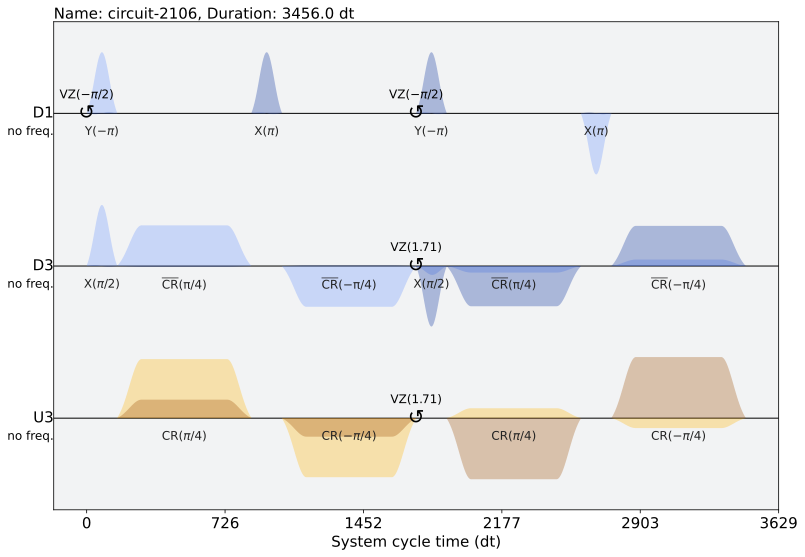

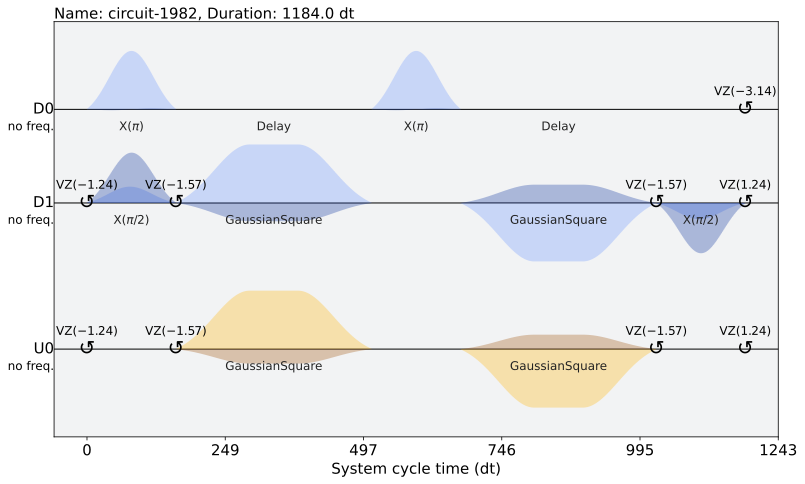

In [29]:
## RZZ
## rzz_pe gate

rzx_basis = ["rzx", "rz", "sx", "x"]
pulse_efficient = PassManager([
        # Consolidate consecutive two-qubit operations.
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates = rzx_basis),
        # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
        EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),
        # Attach scaled CR pulse schedules to the RZX gates.
        RZXCalibrationBuilderNoEcho(backend),
        ## Simplify single-qubit gates.
        UnrollCustomDefinitions(std_eqlib, rzx_basis),
        BasisTranslator(std_eqlib, rzx_basis),
        Optimize1qGatesDecomposition(rzx_basis),
    ]
)

# Template substitution
pass_ = TemplateOptimization(**rzx_templates())
qc_TO = PassManager(pass_).run(rzz_pe(t=tt).decompose())

# Simplify gates
gates = ["rzx", "rz", "sx", "x"]
qc_rzx = transpile(qc_TO,
                   fake_jakarta_backend,
                   optimization_level=1,
                   basis_gates = gates)

## Add pulse efficient schedules
qc_pe = pulse_efficient.run(qc_rzx)

# Compare the optimized gate using CNOTs and the pulse efficient implementation 
print('='*80)
print("Displaying schedules of the RZZ gates")
print('='*80)
display(schedule(transpile(rzz_cnot(t=tt), fake_jakarta_backend, optimization_level=3), fake_jakarta_backend).draw())
display(schedule(qc_pe, fake_jakarta_backend).draw())

Displaying schedules of the RYY gates


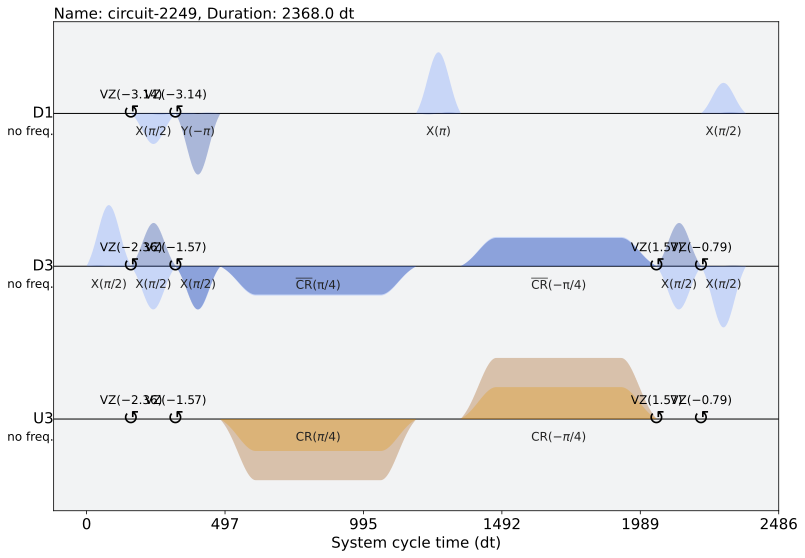

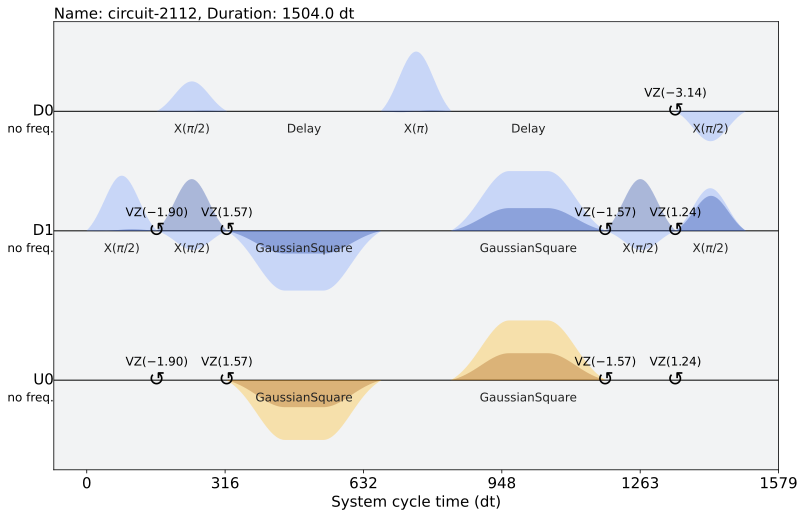

In [30]:
## RYY
## ryy_pe gate

# Template substitution
pass_ = TemplateOptimization(**rzx_templates())
qc_TO = PassManager(pass_).run(ryy_pe(t=tt).decompose())

# Simplify gates
gates = ["rzx", "rz", "sx", "x"]
qc_rzx = transpile(qc_TO,
                   fake_jakarta_backend,
                   optimization_level=1,
                   basis_gates = gates)

# Add pulse efficient schedules
qc_pe = pulse_efficient.run(qc_rzx)

# Compare the optimized gate using CNOTs and the pulse efficient implementation 
print('='*80)
print("Displaying schedules of the RYY gates")
print('='*80)
display(schedule(transpile(ryy_cnot(t=tt), fake_jakarta_backend, optimization_level=3), fake_jakarta_backend).draw())
display(schedule(qc_pe, fake_jakarta_backend).draw())

Displaying schedules of the RXX gates


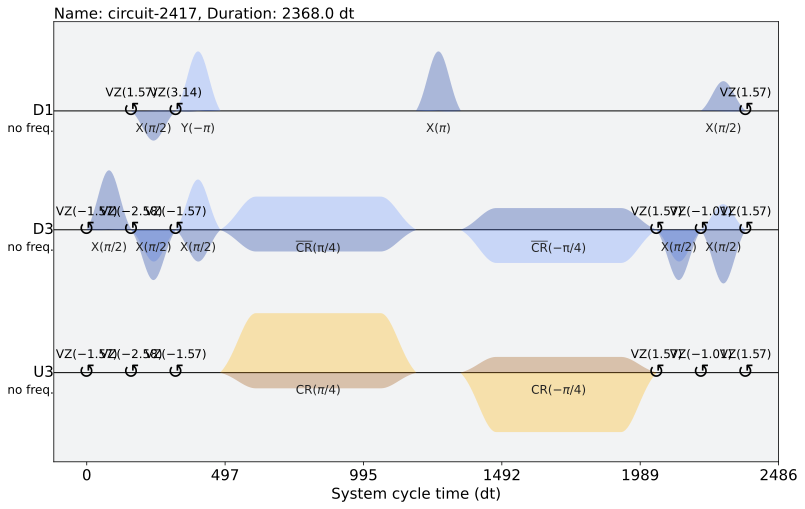

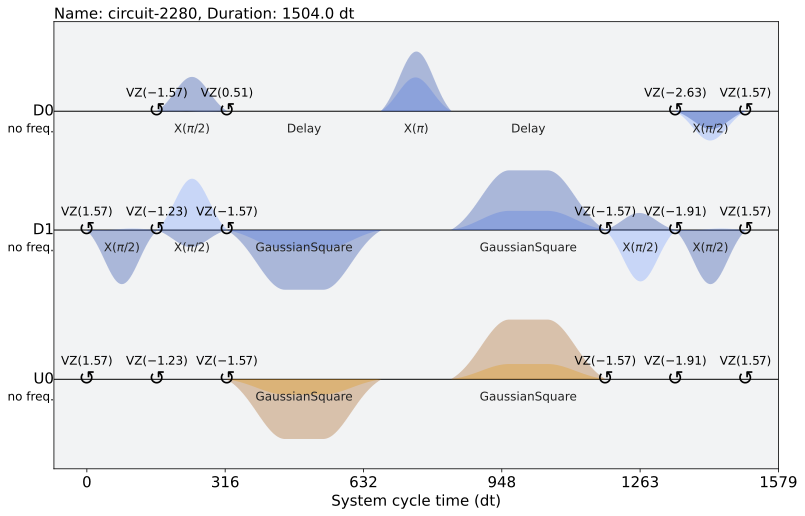

In [31]:
## Rxx
## rxx_pe gate

# Template optimization
pass_ = TemplateOptimization(**rzx_templates())
qc_TO = PassManager(pass_).run(rxx_pe(t=tt).decompose())

# Simplify gates
gates = ["rzx", "rz", "sx", "x"]
qc_rzx = transpile(qc_TO,
                   fake_jakarta_backend,
                   optimization_level=1,
                   basis_gates = gates)

# Add pulse efficient schedules
qc_pe = pulse_efficient.run(qc_rzx)

# Compare the optimized gate using CNOTs and the pulse efficient implementation 
print('='*80)
print("Displaying schedules of the RXX gates")
print('='*80)
display(schedule(transpile(rxx_cnot(t=tt), fake_jakarta_backend, optimization_level=3), fake_jakarta_backend).draw())
display(schedule(qc_pe, fake_jakarta_backend).draw())

In the three cases, the duration of the schedules is significantly lower for the circuits after template optimization. We can also see the gate implementation using the `rzx` basis prior to adding the pulse schedules:

Pulse-efficient RZZ gate


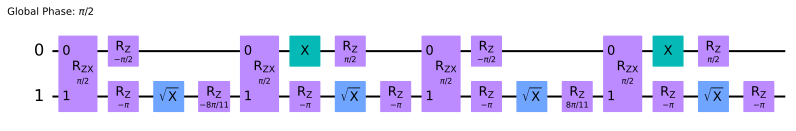

Pulse-efficient RYY gate


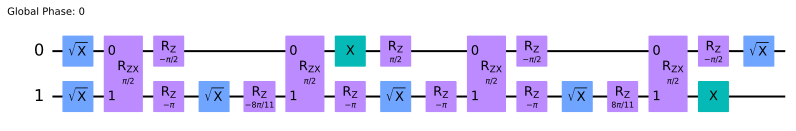

Pulse-efficient RXX gate


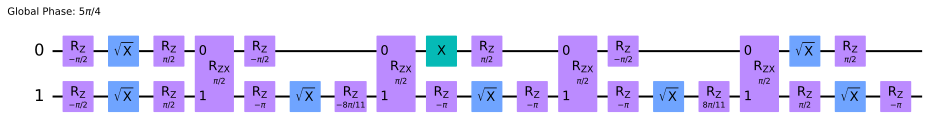

In [32]:
###### RZZ

print('='*80)
print("Pulse-efficient RZZ gate")
print('='*80)

pass_ = TemplateOptimization(**rzx_templates())
qc_TO = PassManager(pass_).run(rzz_pe(t=3*np.pi/11).decompose())

gates = ["rzx", "rz", "sx", "x"]
qc_rzx = transpile(qc_TO,
                   fake_jakarta_backend,
                   optimization_level=1,
                   basis_gates = gates)

qc_rzx = remove_idle_qwires(qc_rzx)
display(qc_rzx.draw())

###### RYY

print('='*80)
print("Pulse-efficient RYY gate")
print('='*80)

pass_ = TemplateOptimization(**rzx_templates())
qc_TO = PassManager(pass_).run(ryy_pe(t=3*np.pi/11).decompose())

gates = ["rzx", "rz", "sx", "x"]
qc_rzx = transpile(qc_TO,
                   fake_jakarta_backend,
                   optimization_level=1,
                   basis_gates = gates)

qc_rzx = remove_idle_qwires(qc_rzx)
display(qc_rzx.draw())

###### RXX

print('='*80)
print("Pulse-efficient RXX gate")
print('='*80)

pass_ = TemplateOptimization(**rzx_templates())
qc_TO = PassManager(pass_).run(rxx_pe(t=3*np.pi/11).decompose())

gates = ["rzx", "rz", "sx", "x"]
qc_rzx = transpile(qc_TO,
                   fake_jakarta_backend,
                   optimization_level=1,
                   basis_gates = gates)

qc_rzx = remove_idle_qwires(qc_rzx) 
display(qc_rzx.draw())

## V.3 Simulations with Pulse-Efficient Template Optimization and Measurement Error Mitigation

We can now proceed to  calculate the state fidelities using the template substitution to generate pulse-efficient schedules and mitigate measurement errors on the results using the measurement filter calculated in Sec. [4.5](#Native-Gates---Optimization-Level-3-with-Measurement-Error-Mitigation). 

In the function `run_and_evaluate_with_steps_pe_mem`, we will create the Trotter circuit with the number of Trotter steps defined by `trotter_steps` and generate a pulse efficient run of the final circuit. It will run the final results through `meas_filter` and return both unmitigated and mitigated results for each run.

In [33]:
def run_and_evaluate_with_steps_pe_mem(trotter_steps, backend, meas_filter=meas_filter):
    
   ########################
    ###### Time Evolution
    ########################
    pulse_efficient = PassManager([
        # Consolidate consecutive two-qubit operations.
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates = rzx_basis),
        # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
        EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),
        # Attach scaled CR pulse schedules to the RZX gates.
        RZXCalibrationBuilderNoEcho(backend),
        ## Simplify single-qubit gates.
        UnrollCustomDefinitions(std_eqlib, rzx_basis),
        BasisTranslator(std_eqlib, rzx_basis),
        Optimize1qGatesDecomposition(rzx_basis)
    ])

    # The final time of the state evolution
    target_time = np.pi

    # Number of trotter steps
    #trotter_steps = 8  ### CAN BE >= 4

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7, name='qrT')
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    for _ in range(trotter_steps):
        qc.append(rzz_pe((target_time/trotter_steps)), [1,3])
        qc.append(ryy_pe((target_time/trotter_steps)), [1,3])
        qc.append(rxx_pe((target_time/trotter_steps)), [1,3])

        qc.append(rzz_pe((target_time/trotter_steps)), [3,5])
        qc.append(ryy_pe((target_time/trotter_steps)), [3,5])
        qc.append(rxx_pe((target_time/trotter_steps)), [3,5])


    # Template Optimization - see Earnest+ 
    pass_ = TemplateOptimization(**rzx_templates())
    qc_TO = PassManager(pass_).run(qc.decompose())

    # Simplify gates
    gates = ["rzx", "rz", "sx", "x"]
    transpiled_qc_rzx = transpile(qc_TO,
                       fake_jakarta_backend,
                       optimization_level=1,
                       basis_gates = gates)

    # Add pulse efficient schedules
    qc_pe = pulse_efficient.run(transpiled_qc_rzx)

    #Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc_pe, [1,3,5])

    ########################
    ###### Execution
    ########################
    
    shots = 8192
    reps = 8


    jobs = []
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots)
        print('Job ID', job.job_id())
        jobs.append(job)
        
    # Compute unmitigated tomography fidelities for each repetition
    fids_unmitigated = []
    for job in jobs:
        fid = state_tomo(job.result(), st_qcs)
    #         print(job.result())
    #    job_mitigated_results = meas_filter.apply(job.result())
    #    fid = state_tomo(job_mitigated_results, st_qcs) ## UF
        fids_unmitigated.append(fid)
        
    # Compute mitigated tomography fidelities for each repetition
    fids_mitigated = []
    for job in jobs:
#        fid = state_tomo(job.result(), st_qcs)
#         print(job.result())
        job_mitigated_results = meas_filter.apply(job.result())
        fid = state_tomo(job_mitigated_results, st_qcs) ## UF
        fids_mitigated.append(fid)
        
    print('='*80)    
    print('\n Duration ={:.0f}'.format(schedule(transpile(qc_pe, backend),backend).duration)) 
    print('\n Unmitigated state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids_unmitigated), 
                                                                                   np.std(fids_unmitigated)))
    print('\n Mitigated state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids_mitigated), 
                                                                                 np.std(fids_mitigated)))
    print('='*80)
    
    return round(np.mean(fids_unmitigated),4), round(np.mean(fids_mitigated),4)

In [34]:
## Running between n=4 and n=13 Trotter steps by default
# *****************
## CAUTION 
# because of template optimization, it takes
# about 1h30 to 2h to run this function for the 10 evaluations of different Trotter steps
# One can change n_min_trotter and/or n_max_trotter to run it faster, but the plotting function
# below will not work.
#
# Other than the plotting below, not running this cell won't affect any other cell in this notebook
# *****************

if run_simulations == True:
    list_avgs_standard_pe, list_avgs_standard_pe_mem = execute_Trotter_jobs(run_and_evaluate_with_steps_pe_mem, 
                                                 backend=fake_jakarta_backend, 
                                                 title='PE Template Optimization and MEM')

In [35]:
if run_simulations == True:
    plot_comparisons_trotter([list_avgs_noiseless,
                              list_avgs_standard, 
                              list_avgs_standard_opt,
                              list_avgs_standard_opt_mem, 
                              list_avgs_standard_pe,
                              list_avgs_standard_pe_mem])
    plt.savefig('images/final_simulations.svg',  bbox_inches="tight")

As we can see, the pulse efficient circuits have much higher state fidelities for essentially all Trotter steps, with average state fidelities of $\approx 0.80-0.85$ for `trotter_steps` $10 \lesssim n \lesssim 13$.   

# VI. Jakarta Experiments

[[Go Back to Table of Contents](#I.-Quantum-Simulation-of-the-XXX-Heisenberg-Spin-Model-with-IBMQ-Jakarta)]

With the results of the simulations, we can run the final experiments directly on the Jakarta device. Before running the Trotter circuit, we first calculate the measurement filter to be used for error mitigation. 

We report the state fidelity for 3 runs. First, we show an example of Jakarta run with native gates, `optimization-level=3`, and measurement error mitigation for $n=8$ Trotter steps. In subsection VI.5, we obtain  __our highest state fidelity using pulse-efficient gates with measurement error mitigation and $n=11$ Trotter steps__. As a point of comparison, we also show the result of a similar job with $n=8$ Trotter steps.

## VI.1 Qiskit's Error Mitigation Calibration

We need first to execute the calibrations for `meas-filter` on the actual Jakarta device. The function below performs this calibration. It can be run in one of two ways: either by loading a pre-run job available at IBM Quantum service (`job_id = '625647d29def42732fa98d01'`) when the parameter `running_on_device= False`, or by setting `running_on_device= True` to obtain a new measurement filter from Jakarta.

In [36]:
def calculate_meas_filter(backend=jakarta_backend, running_on_device = False, job_id = '625647d29def42732fa98d01'):
    '''
    
    Measurement error mitigation strategy based on a simple Pauli error model 
    assigning a probability p of an X bit flip defined on function `get_noise()`. 
    
    Returns measurement filter to mitigate measurement errors applied to job results.
    
    
    '''
    qr = QuantumRegister(7)
    qubit_list=[1,3,5]
    meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

    ## used to run on device. Once it is run, just pull the results from the jobs 
    if running_on_device == True:
        # Execute the calibration circuits without noise
        t_qc = transpile(meas_calibs, backend)
        qobj = assemble(t_qc, shots=10000)
        cal_results = backend.run(qobj, shots=10000).result()
    else:
#        job_id = '625647d29def42732fa98d01' # Default is calibration from jakarta
        cal_results = backend.retrieve_job(job_id).result()

    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
    # Get the filter object
    meas_filter = meas_fitter.filter

    return meas_filter

In [37]:
## complete_meas_cal from job on device when running_on_device = False. 
## Set running_on_device = True for a new Jakarta job
meas_filter = calculate_meas_filter(jakarta_backend, running_on_device = False)

## VI.2 Native  gates - Optimization Level 3 with Measurement Error Mitigation

The function below is the same as the one in section [4.4](##Native-Gates---Optimization-Level-30-with-Measurement-Error-Mitigation), except for the parameters `running_on_device` and `list_jobs`. If `running_on_device=False`, it will use the pre-run list of jobs in `list_jobs` to return the results of jobs previously run on Jakarta. If set to `running_on_device=True`, it will run new jobs on Jakarta.

In [38]:
def run_and_evaluate_with_steps_opt_mem_jakarta(trotter_steps, backend, meas_filter = meas_filter, 
                                               running_on_device = False, list_jobs=None):
    '''
    This function reads jobs already on device or runs new ones using the same approach as   
    `run_and_evaluate_with_steps_opt_mem` from section 4.4
    
    Usage: run_and_evaluate_with_steps_opt_mem_device(trotter_steps, backend, meas_filter = meas_filter, 
                                                        running_on_device = False, list_jobs=None)
                                               
    trotter_steps: number of Trotter steps 
    backend: device or simulation backend.
    meas_filter: meas_filter calculated on backend
    running_on_device = False: 'False' to read list of finished jobs or 'True'to run new ones. Default is 'False'
    list_jobs: list of jobs already executed on device. Default is None
    
    Returns: Mean fidelity of state compared to target_state
    '''
            

   ########################
    ###### Time Evolution
    ########################

    # The final time of the state evolution
    target_time = np.pi
    
    qr_trotter = QuantumRegister(3)
    qc_trotter = QuantumCircuit(qr_trotter)
    
    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(trotter_steps):
        qc_trotter.append(return_standard_Trott(target_time/trotter_steps),[qr_trotter[0], 
                                                                            qr_trotter[1], 
                                                                            qr_trotter[2]])
    qc_trotter = transpile(qc_trotter, backend=backend, optimization_level=3, initial_layout=[1,3,5])
    
    #display(qc_trotter.draw())
    
    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7, name='qrT')
    qc = QuantumCircuit(qr)


    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    qc.append(qc_trotter, [qr[0],qr[1], qr[2],qr[3], qr[4],qr[5],qr[6]])


#     # Initialize quantum circuit for 3 qubits
#     qr = QuantumRegister(7)
#     qc = QuantumCircuit(qr)

#     # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
#     qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

#     # Simulate time evolution under H_heis3 Hamiltonian
#     for _ in range(trotter_steps):
#         qc.append(return_standard_Trott(target_time/trotter_steps), [qr[1], qr[3], qr[5]])


    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
    
#     # Optimization
#     #  Transpile the circuit using the optimizations of optimization_level=3
#     st_qcs = transpile(st_qcs, backend=backend, optimization_level=3)

    # Uncomment to see the final transpilation 
    #display(st_qcs[-1].decompose().draw())  # view decomposition of trotter gates

    if running_on_device == True: 
    
        ########################
        ###### Execution
        ########################
        
        shots = 8192
        reps = 8

        jobs = []
        for _ in range(reps):
            # execute
            job = execute(st_qcs, backend, shots=shots)
            print('Job ID', job.job_id())
    

    elif running_on_device == False:
        ########################
        ###### READ
        ########################
        
        if list_jobs == None:
            print("Provide list_jobs")
        else:
            jobs = []
            for j in list_jobs:
                # retrieve
                job = backend.retrieve_job(j)
                print('Job ID', job.job_id())
                jobs.append(job)
        

    else:
        print('Define `running_on_device`')
        
    # Compute unmitigated tomography fidelities for each repetition
    fids_unmitigated = []
    for job in jobs:
        fid = state_tomo(job.result(), st_qcs)
        fids_unmitigated.append(fid)
        
        
    # Compute mitigated tomography fidelities for each repetition
    fids_mitigated = []
    for job in jobs:
        job_mitigated_results = meas_filter.apply(job.result())
        fid = state_tomo(job_mitigated_results, st_qcs) ## UF
        fids_mitigated.append(fid)
        
    print('='*80)    
    print('\n Duration ={:.0f}'.format(schedule(transpile(st_qcs[-1], backend),backend).duration)) 
    print('\n Unmitigated state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids_unmitigated), 
                                                                                   np.std(fids_unmitigated)))
    print('\n Mitigated state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids_mitigated), 
                                                                                 np.std(fids_mitigated)))
    print('='*80)
    
    return round(np.mean(fids_unmitigated),4), round(np.mean(fids_mitigated),4)
        


## <font color ='blue'> VI.3 FINAL RUN: Native Gates - Optimization Level 3 with Measurement Error Mitigation</font>

Actual run of the Trotter circuit using native gates on the Jakarta device for 8 Trotter steps.

In [39]:
# from opt-mem nb
list_jobs_opt_n8 = ['62596a59736894d774c8b4c4',
                    '62596a5ba7e9662191dee0aa',
                    '62596a5d0d8f19156bac1299',
                    '62596a5f35e1ec4258252f6f',
                    '62596a618e4b234f45d3023f',
                    '62596a6a8e4b2304fad30240',
                    '62596a778e4b23762ed30241',
                    '62596a78e1f2456b36eb64d4'] ## Trotter opt n=8  

run_and_evaluate_with_steps_opt_mem_jakarta(8, jakarta_backend, meas_filter, running_on_device = False, 
                                           list_jobs=list_jobs_opt_n8)

## To run a new job in Jakarta using the native gates with MEM, uncomment the line below
#run_and_evaluate_with_steps_opt_mem_jakarta(8, jakarta_backend, meas_filter, running_on_device = True)

Job ID 62596a59736894d774c8b4c4
Job ID 62596a5ba7e9662191dee0aa
Job ID 62596a5d0d8f19156bac1299
Job ID 62596a5f35e1ec4258252f6f
Job ID 62596a618e4b234f45d3023f
Job ID 62596a6a8e4b2304fad30240
Job ID 62596a778e4b23762ed30241
Job ID 62596a78e1f2456b36eb64d4

 Duration =104880

 Unmitigated state tomography fidelity = 0.4195 ± 0.0068

 Mitigated state tomography fidelity = 0.4745 ± 0.0081


(0.4195, 0.4745)

## VI.4 Pulse Efficient Template Optimization

The function below is the same as the one in section [5.3](#Simulations-with-Pulse-Efficient-Template-Optimization-and-Measurement-Error-Mitigation), except for the parameters `running_on_device` and `list_jobs`. If `running_on_device=False`, it will use the pre-run list of jobs in `list_jobs` to return the results of jobs previously run on Jakarta. If set to `running_on_device=True`, it will run new jobs on Jakarta.

In [40]:
def run_and_evaluate_with_steps_pe_mem_jakarta(trotter_steps, backend, meas_filter = meas_filter, 
                                               running_on_device = False, list_jobs=None):
    '''
    This function reads jobs already on device or runs new ones using the same approach as   
    `run_and_evaluate_with_steps_opt_mem` from section 3.5
    
    Usage: run_and_evaluate_with_steps_opt_mem_device(trotter_steps, backend, meas_filter = meas_filter, 
                                                        read_or_run = 'read', list_jobs=None)
                                               
    trotter_steps: number of Trotter steps 
    backend: device or simulation backend.
    meas_filter: meas_filter calculated on backend
    read_or_run: 'read' to read finished jobs or 'run'to run new ones. Default is 'read'
    list_jobs: list of jobs already executed on device. Default is None
    
    Returns: Mean fidelity of state compared to target_state
    '''
    
   ########################
    ###### Time Evolution
    ########################
    pulse_efficient = PassManager([
        # Consolidate consecutive two-qubit operations.
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates = rzx_basis),
        # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
        EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),
        # Attach scaled CR pulse schedules to the RZX gates.
        RZXCalibrationBuilderNoEcho(backend),
        ## Simplify single-qubit gates.
        UnrollCustomDefinitions(std_eqlib, rzx_basis),
        BasisTranslator(std_eqlib, rzx_basis),
        Optimize1qGatesDecomposition(rzx_basis)
    ])

    # The final time of the state evolution
    target_time = np.pi

    # Number of trotter steps
    #trotter_steps = 8  ### CAN BE >= 4

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7, name='qrT')
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    for _ in range(trotter_steps):
        qc.append(rzz_pe((target_time/trotter_steps)), [1,3])
        qc.append(ryy_pe((target_time/trotter_steps)), [1,3])
        qc.append(rxx_pe((target_time/trotter_steps)), [1,3])

        qc.append(rzz_pe((target_time/trotter_steps)), [3,5])
        qc.append(ryy_pe((target_time/trotter_steps)), [3,5])
        qc.append(rxx_pe((target_time/trotter_steps)), [3,5])


    #display(qc.draw())
    pass_ = TemplateOptimization(**rzx_templates())
    qc_TO = PassManager(pass_).run(qc.decompose())

    gates = ["rzx", "rz", "sx", "x"]
    transpiled_qc_rzx = transpile(qc_TO,
                       fake_jakarta_backend,
                       optimization_level=1,
                       basis_gates = gates)

    #display(transpiled_qc_rzx.draw())
    qc_pe = pulse_efficient.run(transpiled_qc_rzx)

    #Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc_pe, [1,3,5])

    if running_on_device == True: 
        ########################
        ###### Execution
        ########################

        shots = 8192
        reps = 8


        jobs = []
        for _ in range(reps):
            # execute
            job = execute(st_qcs, backend, shots=shots)
            print('Job ID', job.job_id())
            jobs.append(job)
            
    elif running_on_device == False:
        ########################
        ###### READ
        ########################
        
        if list_jobs == None:
            print("Provide list_jobs")
        else:
            jobs = []
            for j in list_jobs:
                # retrieve
                print('Job ID', job.job_id())
                job = backend.retrieve_job(j)
                jobs.append(job)
        

    else:
        print('Define `running_on_device`')
        
    # Compute unmitigated tomography fidelities for each repetition
    fids_unmitigated = []
    for job in jobs:
        fid = state_tomo(job.result(), st_qcs)
    #         print(job.result())
    #    job_mitigated_results = meas_filter.apply(job.result())
    #    fid = state_tomo(job_mitigated_results, st_qcs) ## UF
        fids_unmitigated.append(fid)
        
    # Compute mitigated tomography fidelities for each repetition
    fids_mitigated = []
    for job in jobs:
#        fid = state_tomo(job.result(), st_qcs)
#         print(job.result())
        job_mitigated_results = meas_filter.apply(job.result())
        fid = state_tomo(job_mitigated_results, st_qcs) ## UF
        fids_mitigated.append(fid)
        
    print('='*80)    
    print('\n Duration ={:.0f}'.format(schedule(transpile(qc_pe, backend),backend).duration)) 
    print('\n Unmitigated state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids_unmitigated), 
                                                                                   np.std(fids_unmitigated)))
    print('\n Mitigated state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids_mitigated), 
                                                                                 np.std(fids_mitigated)))
    print('='*80)
    
    return round(np.mean(fids_unmitigated),4), round(np.mean(fids_mitigated),4)
        

## <font color ='blue'>VI.5 FINAL RUN: Pulse-Efficient Gates with Measurement Error Mitigation</font>


Jobs from Jakarta device with pulse-efficient gates and measurement error mitigation. The first one is for $n=11$ Trotter steps and will return _the highest state fidelity of our Jakarta experiments_ and the second for $n=8$ Trotter steps for comparison.


In [41]:
# ## N=11
# list_jobs_pe_n11 = ['625b5cc473689461f9c8bced',
#                     '625b5cca8e4b231934d30a38',
#                     '625b5cce35e1ec41d9253740',
#                     '625b5cd3f1fb8d67323ad92d',
#                     '625b5cd87368941e87c8bcee',
#                     '625b5cdda7e96664addee873',
#                     '625b5ce20d8f1980abac1aaf',
#                     '625b5ce7e3b67fc84a3abd81']

# run_and_evaluate_with_steps_pe_mem_jakarta(11, jakarta_backend, meas_filter, running_on_device = False, 
#                                            list_jobs=list_jobs_pe_n11)


### Switch to `run_new_Jakarta_job = True` to run a new set of jobs with N=11 in Jakarta
run_new_Jakarta_job = False
if run_new_Jakarta_job == True:
    run_and_evaluate_with_steps_pe_mem_jakarta(11, jakarta_backend, meas_filter, running_on_device = True)


In [42]:
### N=8

# list_jobs_pe_n8 = ['625b5ae0f1fb8d40af3ad927',
#                     '625b5ae4e1f245f2cdeb6ce4',
#                     '625b5ae90d8f19451bac1aaa',
#                     '625b5aed9e311582cf838b50',
#                     '625b5af13bbc9fb061735c4e',
#                     '625b5af5736894b9c6c8bce7',
#                     '625b5af98e4b23cb72d30a36',
#                     '625b5afda7e9666acddee870']

# run_and_evaluate_with_steps_pe_mem_jakarta(8, jakarta_backend, meas_filter, running_on_device = False, 
#                                            list_jobs=list_jobs_pe_n8)

### Switch to `run_new_Jakarta_job = True` to run a new set of jobs with N=8 in Jakarta
run_new_Jakarta_job = False
if run_new_Jakarta_job == True:
    run_and_evaluate_with_steps_pe_mem_jakarta(8, jakarta_backend, meas_filter, running_on_device = True)

In [ ]:
#print('Job_status', job_monitor(backend.retrieve_job('625b5ae0f1fb8d40af3ad927')))

# VII. Conclusions and Future Directions

[[Go Back to Table of Contents](#I.-Quantum-Simulation-of-the-XXX-Heisenberg-Spin-Model-with-IBMQ-Jakarta)]

For this IBMQ Open Science Prize, we were asked to simulate an XXX Heisenberg spin model with three spin $1/2$ particles using Jakarta, one of IBM's 7 -qubit quantum computers. Such simulations are essential in the NISQ (Noisy Intermediate-Scale Quantum) era to explore the simulation possibilities of quantum computers and advance the state of NISQ algorithms ([Preskill 2018](https://arxiv.org/abs/1801.00862), [Bharti et al. 2022](https://arxiv.org/abs/2101.08448)). In this notebook, we walked through different approaches and methodologies to simulate the Hamiltonian and obtain the $|110\rangle$ state dynamics using both Qiskit native and pulse-efficient gates with and without measurement error mitigation. The results of our different __simulations__ executed on the `FakeJakarta` backend are seen in the figure below.

<img src ='images/final_simulations.svg' >

<div class="alert alert-block alert-info">
 <font color=black> With these results, we report three experiments run on Jakarta using the parameters with the highest state fidelities in our simulations. Of these, the <b>Trotter simulation using pulse-efficient gates obtained with template optimization and measurement error mitigation for N=11 Trotter steps</b> should result in the <b>highest state fidelity of our experiments, with results $\approx$ 0.80-0.85</b>. </font>
<div>

There are alternatives to potentially improve these results even further. As mentioned when discussing measurement error mitigation on section [4.4](##Native-Gates---Optimization-Level-30-with-Measurement-Error-Mitigation), there are alternative approaches to error mitigation we could implement, such as [zero noise extrapolation](https://mitiq.readthedocs.io/en/stable/guide/zne.html) ([Temme et al. 2017](https://arxiv.org/abs/1612.02058), [Kandala et al. 2019](https://arxiv.org/abs/1805.04492)) using packages such as [mitiq](https://mitiq.readthedocs.io/) ([LaRose et al. 2020](https://arxiv.org/abs/2009.04417)). This approach has been used successfully in noisy circuits (see, e.g., ([Kandala et al. 2019](https://arxiv.org/abs/1805.04492), [Kim et al. 2021](https://arxiv.org/abs/2108.09197))) and it would be interesting to compare its performance with the measurement error strategy used here. 

Another alternative would be to use [quantum error correction](https://en.wikipedia.org/wiki/Quantum_error_correction) (see ([Wootton 2020](https://arxiv.org/abs/2004.11037)), particularly repetition codes using the remaining qubits on the Jakarta device to attempt minimizing errors during the calculations. A third approach to improve the state fidelity would be to use compiler modifications that augment the basis gate set using pulse ([Gokhale et al. 2020](https://arxiv.org/abs/2004.11205), [Smith et al. 2022](https://arxiv.org/abs/2202.13600)). It will be interesting to implement and verify if these additional approaches improve the fidelity of simulations using noisy quantum processors in the NISQ era. 

_Added post-submission_ 

Below, we can also see the $|110\rangle$ state evolution under the different methodologies obtained in Appendix A below.

<img src ='images/final_state_evolution_simulations.svg' width=800>

---
---

# Appendix (_added post-submission_): Comparison with exact solution

## A.1 Exact solution using classical simulation

In [44]:
# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H


# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

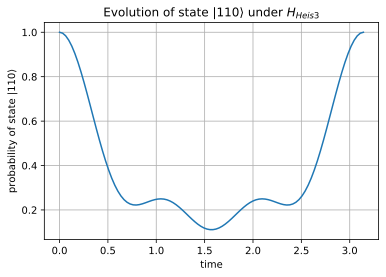

In [45]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110 = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110)
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()

## A.2 Quantum simulations

### A.2.1 Native gates 

In [67]:
def run_and_evaluate_with_steps_probs(state, target_time, trotter_steps, backend):
    
   ########################
    ###### Time Evolution
    ########################

    # The final time of the state evolution
    target_time = target_time

    qr_trotter = QuantumRegister(3)
    qc_trotter = QuantumCircuit(qr_trotter)
    
    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(trotter_steps):
        qc_trotter.append(return_standard_Trott(target_time/trotter_steps),[qr_trotter[0], 
                                                                            qr_trotter[1], 
                                                                            qr_trotter[2]])
#    qc_trotter = transpile(qc_trotter, backend=backend, optimization_level=3, initial_layout=[1,3,5])
    
#    display(qc_trotter.draw())
    
    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7, name='qrT')
    cr = ClassicalRegister(3)
    qc = QuantumCircuit(qr,cr)


    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    qc.append(qc_trotter, [qr[1], qr[3], qr[5]])


#     # Generate state tomography circuits to evaluate fidelity of simulation
#     st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
    qc.measure([1,3,5],[0,1,2])
#    display(qc.decompose().draw())
    
    ########################
    ###### Execution
    ########################
    
    shots = 8192
    reps = 8

    results_jobs = []
    prob_st = []
    for _ in range(reps):
        # execute
        job = execute(qc,backend,shots=shots)
        print('Job ID', job.job_id())
        results_jobs.append(job.result().get_counts())
        try:
            prob_st.append(job.result().get_counts()[state]/shots)
        except:
            prob_st.append(0)
    
    avg_prob_state = round(np.mean(prob_st),4)
        
    return avg_prob_state

### A.2.2 Native gates optimized

In [46]:
def run_and_evaluate_with_steps_opt_mem_probs(state, target_time, trotter_steps, backend, meas_filter=meas_filter):
    
   ########################
    ###### Time Evolution
    ########################

    # The final time of the state evolution
    target_time = target_time

    qr_trotter = QuantumRegister(3)
    qc_trotter = QuantumCircuit(qr_trotter)
    
    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(trotter_steps):
        qc_trotter.append(return_standard_Trott(target_time/trotter_steps),[qr_trotter[0], 
                                                                            qr_trotter[1], 
                                                                            qr_trotter[2]])
    qc_trotter = transpile(qc_trotter, backend=backend, optimization_level=3, initial_layout=[1,3,5])
    
#    display(qc_trotter.draw())
    
    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7, name='qrT')
    cr = ClassicalRegister(3)
    qc = QuantumCircuit(qr,cr)


    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    qc.append(qc_trotter, [qr[0],qr[1], qr[2],qr[3], qr[4],qr[5],qr[6]])


#     # Generate state tomography circuits to evaluate fidelity of simulation
#     st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
    qc.measure([1,3,5],[0,1,2])
#    display(qc.decompose().draw())
    
    ########################
    ###### Execution
    ########################
    
    shots = 8192
    reps = 8

    results_jobs = []
    prob_st = []
    for _ in range(reps):
        # execute
        job = execute(qc,backend,shots=shots)
        print('Job ID', job.job_id())
        results_jobs.append(job.result().get_counts())
        try:
            prob_st.append(job.result().get_counts()[state]/shots)
        except:
            prob_st.append(0)
    
    avg_prob_state = round(np.mean(prob_st),4)
    
    results_jobs_mitigated = []
    prob_st_mitigated = []
    for job in results_jobs:
        job_mitigated_results = meas_filter.apply(job)
        results_jobs_mitigated.append(job_mitigated_results)
        try:
            prob_st_mitigated.append(job_mitigated_results[state]/shots)
        except:
            prob_st_mitigated.append(0)
        
    avg_prob_state_mitigated = round(np.mean(prob_st_mitigated),4)
    
    return avg_prob_state, avg_prob_state_mitigated

### A.2.3 Pulse Template Optimization

In [47]:

def run_and_evaluate_with_steps_pe_mem_probs(state, target_time, trotter_steps, backend, meas_filter=meas_filter):
    
   ########################
    ###### Time Evolution
    ########################
    pulse_efficient = PassManager([
        # Consolidate consecutive two-qubit operations.
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates = rzx_basis),
        # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
        EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),
        # Attach scaled CR pulse schedules to the RZX gates.
        RZXCalibrationBuilderNoEcho(backend),
        ## Simplify single-qubit gates.
        UnrollCustomDefinitions(std_eqlib, rzx_basis),
        BasisTranslator(std_eqlib, rzx_basis),
        Optimize1qGatesDecomposition(rzx_basis)
    ])

    # The final time of the state evolution
    target_time = target_time

    # Number of trotter steps
    #trotter_steps = 8  ### CAN BE >= 4

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7, name='qrT')
    cr = ClassicalRegister(3)
    qc = QuantumCircuit(qr,cr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    for _ in range(trotter_steps):
        qc.append(rzz_pe((target_time/trotter_steps)), [1,3])
        qc.append(ryy_pe((target_time/trotter_steps)), [1,3])
        qc.append(rxx_pe((target_time/trotter_steps)), [1,3])

        qc.append(rzz_pe((target_time/trotter_steps)), [3,5])
        qc.append(ryy_pe((target_time/trotter_steps)), [3,5])
        qc.append(rxx_pe((target_time/trotter_steps)), [3,5])


    # Template Optimization - see Earnest+ 
    pass_ = TemplateOptimization(**rzx_templates())
    qc_TO = PassManager(pass_).run(qc.decompose())

    # Simplify gates
    gates = ["rzx", "rz", "sx", "x"]
    transpiled_qc_rzx = transpile(qc_TO,
                       fake_jakarta_backend,
                       optimization_level=1,
                       basis_gates = gates)

    # Add pulse efficient schedules
    qc_pe = pulse_efficient.run(transpiled_qc_rzx)
    qc_pe.measure([1,3,5],[0,1,2])

#     #Generate state tomography circuits to evaluate fidelity of simulation
#     st_qcs = state_tomography_circuits(qc_pe, [1,3,5])

    ########################
    ###### Execution
    ########################
    
    shots = 8192
    reps = 8


    results_jobs = []
    prob_st = []
    for _ in range(reps):
        # execute
        job = execute(qc_pe, backend,shots=shots)
        print('Job ID', job.job_id())
        results_jobs.append(job.result().get_counts())
        try:
            prob_st.append(job.result().get_counts()[state]/shots)
        except:
            prob_st.append(0)
    
    avg_prob_state = round(np.mean(prob_st),4)
    
    results_jobs_mitigated = []
    prob_st_mitigated = []
    for job in results_jobs:
        job_mitigated_results = meas_filter.apply(job)
        results_jobs_mitigated.append(job_mitigated_results)
        try:
            prob_st_mitigated.append(job_mitigated_results[state]/shots)
        except:
            prob_st_mitigated.append(0)
        
    avg_prob_state_mitigated = round(np.mean(prob_st_mitigated),4)
    
    return avg_prob_state, avg_prob_state_mitigated

### A.2.4 Calculations

In [71]:
if run_simulations == True:
    # Noiseless
    prob_st_noiseless_list =[]
    for t in np.linspace(0.0,np.pi,5):
        print("*"*80)
        print('Time ', t)

        avg_prob_state_noiseless = run_and_evaluate_with_steps_probs(state = '110', 
                                                                            target_time= t,
                                                                            trotter_steps = 13, 
                                                                            backend=sim)
        prob_st_noiseless_list.append(avg_prob_state_noiseless)

********************************************************************************
Time  0.0
Job ID 3601d20e-f3cb-49b3-9836-ea0805cbe407
Job ID 3a9312c7-6101-46b4-9503-07332b10208e
Job ID e50706cb-658b-4c28-983c-1647d9fded5a
Job ID c9af1e7f-d3f1-48ab-aabf-c70e3b598912
Job ID 9ea61ffe-5fb9-49e7-b245-f24dedfd2d12
Job ID 5a690389-41f5-4cc4-8b92-9f49e9e4ee0f
Job ID 75d065e1-855d-4077-b102-21008ad8a851
Job ID 464024b3-2160-497b-8af0-725c8cc0bbaa
********************************************************************************
Time  0.7853981633974483
Job ID dfa6cc86-f25e-4646-ac99-08333260b21f
Job ID 188c1f04-e023-4dac-b33f-d401d5e072cf
Job ID 3c69140b-323f-4ccb-ae0c-5d2e2101c54d
Job ID 88034981-a591-45b4-ba30-5ead4cd4f9c2
Job ID f922a04f-d452-473d-9e81-739e92c09372
Job ID 85b12943-8a0e-476b-a2aa-09620213b28d
Job ID a095f3f5-a4dc-4699-9ae1-83ff21562fc8
Job ID cefba808-9b53-490b-951a-a945a10654e7
********************************************************************************
Time  1.5707963267

In [84]:
if run_simulations == True:

    # Native Gates
    prob_st_native_list =[]
    for t in np.linspace(0.0,np.pi,5):
        print("*"*80)
        print('Time ', t)

        avg_prob_state_native = run_and_evaluate_with_steps_probs(state = '110', 
                                                                    target_time= t,
                                                                    trotter_steps = 8, 
                                                                    backend=fake_jakarta_backend)
        prob_st_native_list.append(avg_prob_state_native)

In [48]:
if run_simulations == True:
    ### Obtaining filter for measurement error mitigation
    meas_filter = calculate_meas_filter_noise_from_backend(sim_noisy_jakarta)

Backend Noise + Sim


In [49]:
if run_simulations == True:

    # Noiseless Opt 3 with and without mitigation
    prob_st_opt_list =[]
    prob_st_opt_mitigated_list = []
    for t in np.linspace(0.0,np.pi,5):
        print("*"*80)
        print('Time ', t)

        avg_prob_state_opt, avg_prob_state_opt_mitigated = run_and_evaluate_with_steps_opt_mem_probs(state = '110', 
                                                                                            target_time= t,
                                                                                            trotter_steps = 8, 
                                                                                            backend=fake_jakarta_backend, 
                                                                                            meas_filter=meas_filter)
        prob_st_opt_list.append(avg_prob_state_opt)
        prob_st_opt_mitigated_list.append(avg_prob_state_opt_mitigated)    

********************************************************************************
Time  0.0
Job ID 7fb08b50-fb23-46ee-ab71-31ddbbad662c
Job ID e4e25fd2-4013-4438-9018-f358823a0180
Job ID 9cac697f-6bc2-43de-987b-422d1ca754c0
Job ID fac0c940-cb52-48de-857b-30db8d44cb48
Job ID 4fad2396-0bc1-4871-84fb-7f5f30faaca3
Job ID 0f1720ce-b877-469e-be47-9dadeaceeae3
Job ID a6ed5e0b-5ebe-4532-b0dc-6dbe0ad81fd8
Job ID 1f55221f-cd54-4165-bed0-bc775609760f
********************************************************************************
Time  0.7853981633974483
Job ID 5b1eb1d5-e6b2-4f9e-a1b7-600363e4d5de
Job ID cb7394e7-45e5-4ca1-a0c0-af02cb67b417
Job ID 35fb4b4a-15d2-47d0-bddb-46e7147f748b
Job ID 0d61ec80-5c53-4325-863b-7f129b179428
Job ID fdd5328e-c0b1-4eb1-9b97-b5f6fd2c3dc8
Job ID 6de744a7-89c9-45f2-928d-d20818010f21
Job ID 96666ec6-f5fa-4f71-b7b3-99e88571d4bb
Job ID 6bddcb86-b642-4101-aa6b-dfdcb4e450e7
********************************************************************************
Time  1.5707963267

In [85]:
if run_simulations == True:
    # Pulse-efficient template with and without mitigation
    prob_st_pe_list =[]
    prob_st_pe_mitigated_list = []
    for t in np.linspace(0,np.pi,5):
        print("*"*80)
        print('Time ', t)

        avg_prob_state, avg_prob_state_mitigated = run_and_evaluate_with_steps_pe_mem_probs(state = '110', 
                                                                                            target_time= t,
                                                                                            trotter_steps = 11, 
                                                                                            backend=fake_jakarta_backend, 
                                                                                            meas_filter=meas_filter)
        prob_st_pe_list.append(avg_prob_state)
        prob_st_pe_mitigated_list.append(avg_prob_state_mitigated)    


## A.2.5 Figure: Evolution of $|110\rangle$ under the Hamiltonian

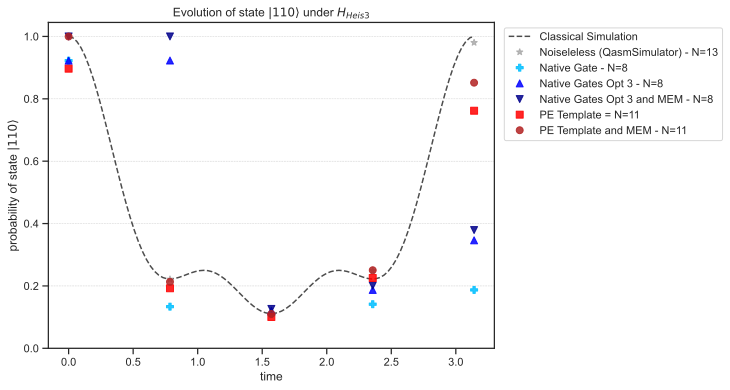

In [82]:
if run_simulations == True:
    time_sim = np.linspace(0,np.pi,5)
    # Plot evolution of |110>

    '*','P', '^', 'v', 's', 'o'

    sns.set(style='ticks', context='notebook')
    fig, ax = plt.subplots(figsize=(8,6))

    plt.plot(ts, probs_110, color='black', linestyle="--", alpha=0.7, label='Classical Simulation')

    plt.plot(time_sim,prob_st_noiseless_list, alpha=0.85, linewidth = 0.0, color='darkgrey', marker='*', 
                     markersize=7, label='Noiseleless (QasmSimulator) - N=13')
    plt.plot(time_sim, prob_st_native_list, alpha=0.85, linewidth = 0.0, color='deepskyblue', marker='P', 
                     markersize=7, label='Native Gate - N=8')
    plt.plot(time_sim,prob_st_opt_list, alpha=0.85, linewidth = 0.0, color='blue', marker='^', 
                     markersize=7, label='Native Gates Opt 3 - N=8')
    plt.plot(time_sim, prob_st_opt_mitigated_list, alpha=0.85, linewidth = 0.0, color='darkblue', marker='v', 
                     markersize=7, label='Native Gates Opt 3 and MEM - N=8')
    plt.plot(time_sim,prob_st_pe_list, alpha=0.85, linewidth = 0.0, color='red', marker='s', 
                     markersize=7, label='PE Template = N=11')
    plt.plot(time_sim, prob_st_pe_mitigated_list, alpha=0.85, linewidth = 0.0, color='firebrick', marker='o', 
                     markersize=7, label='PE Template and MEM - N=11')
    plt.xlabel('time')
    plt.ylabel(r'probability of state $|110\rangle$')
    plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
    #plt.grid()
    plt.legend(loc='best', bbox_to_anchor=(1.01, 0., 0.0, 1.0))
    ax.xaxis.grid(False)
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5)
    ax.set_ylim(ymin=0)
    plt.savefig('images/final_state_evolution_simulations.svg',  bbox_inches="tight")

# VIII. References

[[Alexander et al. 2020]](https://arxiv.org/abs/2004.06755) Alexander, T., N. Kanazawa, D. J. Egger, L. Capelluto, C. J. Wood, A. Javadi-Abhari, and D. C. McKay (2020), Quantum Science and Technology 5 (4), 044006.

[[Bharti et al. 2022]](https://arxiv.org/abs/2101.08448) Bharti, K., A. Cervera-Lierta, T. H. Kyaw, T. Haug, S. Alperin-Lea, A. Anand, M. Degroote, H. Heimonen, J. S. Kottmann, T. Menke, W.-K. Mok, S. Sim, L.-C. Kwek, and A. Aspuru-Guzik (2022), Reviews of Modern Physics 94 (1), 10.1103/revmodphys.94.015004.

[[Earnest et al. 2021]](https://arxiv.org/abs/2105.01063) Earnest, N., C. Tornow, and D. J. Egger (2021), Physical Review Research 3 (4), 10.1103/physrevresearch.3.043088.

[[Gokhale et al. 2020]](https://arxiv.org/abs/2004.11205) Gokhale, P., A. Javadi-Abhari, N. Earnest, Y. Shi, and F. T. Chong (2020), “Optimized quantum compilation for near-term algorithms with openpulse,” 	arXiv:2004.11205 [quant-ph].

[[Heras et al. 2014]](https://arxiv.org/abs/1311.7626) Heras, U. L., A. Mezzacapo, L. Lamata, S. Filipp, A. Wallraff,
and E. Solano (2014), Physical Review Letters 112 (20),
10.1103/physrevlett.112.200501.

[[Iten et al. 2019]](https://arxiv.org/abs/1909.05270) Iten, R., R. Moyard, T. Metger, D. Sutter, and S. Woerner (2019), “Exact and practical pattern matching for quantum circuit optimization,” arXiv:1909.05270 [quant-ph].

[[Kandala et al. 2019]](https://arxiv.org/abs/1805.04492) Kandala, A., K. Temme, A. D. Córcoles, A. Mezzacapo, J. M. Chow, and J. M. Gambetta (2019), Nature 567, 491.

[[Kim et al. 2021]](https://arxiv.org/abs/2108.09197) Kim, Y., C. J. Wood, T. J. Yoder, S. T. Merkel, J. M. Gambetta, K. Temme, and A. Kandala (2021), “Scalable error mitigation for noisy quantum circuits produces competitive expectation values,” arXiv:2108.09197 [quant-ph].

[[LaRose et al. 2020]](https://arxiv.org/abs/2009.04417) LaRose, R., A. Mari, S. Kaiser, P. J. Karalekas, A. A. Alves,
P. Czarnik, M. E. Mandouh, M. H. Gordon, Y. Hindy, A. Robertson, P. Thakre, N. Shammah, and W. J. Zeng (2020), “Mitiq: A software package for error mitigation on noisy quantum computers,” arXiv:2009.04417 [quant-ph].

[[Lloyd 1996]](https://www.science.org/doi/10.1126/science.273.5278.1073) Lloyd, S. (1996), Science 273 (5278), 1073.

[[Nation et al. 2021]](https://arxiv.org/abs/2108.12518) Nation, P. D., H. Kang, N. Sundaresan, and J. M. Gambetta (2021), PRX Quantum 2 (4), 10.1103/prxquantum.2.040326. 

[[Preskill 2018]](https://arxiv.org/abs/1801.00862) Preskill, J. (2018), Quantum 2, 79.


[[Sheldon et al. 2016]](https://arxiv.org/abs/1603.04821) Sheldon, S., E. Magesan, J. M. Chow, and J. M. Gam- betta (2016), Physical Review A 93 (6), 10.1103/physreva.93.060302.

[[Smith et al. 2022]](https://arxiv.org/abs/2202.13600) Smith, K. N., G. S. Ravi, T. Alexander, N. T. Bronn, A. Carvalho, A. Cervera-Lierta, F. T. Chong, J. M. Chow, M. Cubeddu, A. Hashim, L. Jiang, O. Lanes, M. J. Otten, D. I. Schuster, P. Gokhale, N. Earnest, and A. Galda (2022), “Summary: Chicago quantum exchange (cqe) pulse-level quantum control workshop,” arXiv:2202.13600 [quant-ph].

[[Stenger et al. 2021]](https://arxiv.org/abs/2012.11660) Stenger, J. P. T., N. T. Bronn, D. J. Egger, and D. Pekker (2021), Physical Review Research 3 (3), 10.1103/physrevresearch.3.033171.

[[Sundaresan et al. 2020]](https://arxiv.org/abs/2007.02925) Sundaresan, N., I. Lauer, E. Pritchett, E. Magesan, P. Jurcevic, and J. M. Gambetta (2020), PRX Quantum 1 (2), 10.1103/prxquantum.1.020318.

[[Tacchino et al. 2019]](https://arxiv.org/abs/1907.03505) Tacchino, F., A. Chiesa, S. Carretta, and D. Gerace (2019),
Advanced Quantum Technologies 3 (3), 1900052.

[[Temme et al. 2017]](https://arxiv.org/abs/1612.02058) Temme, K., S. Bravyi, and J. M. Gambetta (2017), Physical Review Letters 119 (18), 10.1103/physrevlett.119.180509.

[[Tucci 2005]](https://arxiv.org/abs/quant-ph/0507171) Tucci, R. R. (2005), “An introduction to cartan’s KAK decomposition for QC programmers,” arXiv:quant-ph/0507171.

[[Wootton 2020]](https://arxiv.org/abs/2004.11037) Wootton, J. R. (2020), Quantum Science and Technology 5 (4), 044004.

[[Zhang et al. 2003]](https://arxiv.org/abs/quant-ph/0209120) Zhang, J., J. Vala, S. Sastry, and K. B. Whaley (2003), Physical Review A 67 (4), 10.1103/physreva.67.042313.

In [53]:
import qiskit.tools.jupyter
%qiskit_version_table